<a href="https://colab.research.google.com/github/Harvey-MSKim/MPC-Project---Trajectory-Generation-Using-MPC-For-High-Speed-Overtaking/blob/main/MPC_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

MPC for Multi-Agent Control

Final Project


In [2]:
# This cell is commented out because Polytope package, Pyomo and solvers are already installed on Docker image.
# Please run this cell only if you are using Google Colab. 

# install required dependencies
import sys
IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
  !pip install polytope
  !pip install -q pyomo
  !apt-get install -y -qq glpk-utils
  !apt-get install -y -qq coinor-cbc
  !wget -N -q "https://ampl.com/dl/open/ipopt/ipopt-linux64.zip"
  !unzip -o -q ipopt-linux64

     |████████████████████████████████| 51 kB 2.7 MB/s 
  Created wheel for polytope: filename=polytope-0.2.3-py3-none-any.whl size=46059 sha256=61e02174598cf244c1c5aa71780969ae205d9f2a1049eefd949d9de5f70b1b43
  Stored in directory: /root/.cache/pip/wheels/22/52/02/b0f1baef4767ba74a977b80fff80ea7aff9a5d6468b3c1a900
Successfully built polytope
     |████████████████████████████████| 9.2 MB 3.7 MB/s 
     |████████████████████████████████| 49 kB 4.9 MB/s 
Selecting previously unselected package libsuitesparseconfig5:amd64.
(Reading database ... 155225 files and directories currently installed.)
Preparing to unpack .../libsuitesparseconfig5_1%3a5.1.2-2_amd64.deb ...
Unpacking libsuitesparseconfig5:amd64 (1:5.1.2-2) ...
Selecting previously unselected package libamd2:amd64.
Preparing to unpack .../libamd2_1%3a5.1.2-2_amd64.deb ...
Unpacking libamd2:amd64 (1:5.1.2-2) ...
Selecting previously unselected package libcolamd2:amd64.
Preparing to unpack .../libcolamd2_1%3a5.1.2-2_amd64.deb ...
Un

In [3]:
import polytope as pt
import numpy as np
from __future__ import division
import pyomo.environ as pyo
import matplotlib.pyplot as plt

def minkowski_sum(X, Y):

    # Minkowski sum between two polytopes based on 
    # vertex enumeration. So, it's not fast for the
    # high dimensional polytopes with lots of vertices.
    V_sum = []
    if isinstance(X, pt.Polytope):
        V1 = pt.extreme(X)
    else:
        V1 = X
        
    if isinstance(Y, pt.Polytope):
        V2 = pt.extreme(Y)
    else:
        V2 = Y

    for i in range(V1.shape[0]):
        for j in range(V2.shape[0]):
            V_sum.append(V1[i,:] + V2[j,:])
                    
    return pt.qhull(np.asarray(V_sum))

def pontryagin_diff(X, Y):
    
    # X, Y should have the same dimenson
    # X - Y
    m, n = X.A.shape
    H = [] 
    for i in range(X.A.shape[0]):
        x = cp.Variable(n)
        prob = cp.Problem( cp.Maximize(X.A[i, :] @ x), [Y.A @ x <= Y.b] )
        prob.solve()
        H.append(prob.value)
        
    H = np.reshape(np.asarray(H), (len(H), 1))
        
    return pt.Polytope(X.A, X.b - H)

def precursor(Xset, A, Uset=pt.Polytope(), B=np.array([]), Wset=pt.Polytope()):
    
    if not B.any():
        if not pt.is_empty(Wset):
            return pt.Polytope( pontryagin_diff(Xset, Wset).A @ A, Xset.b)
        else:
            return pt.Polytope(Xset.A @ A, Xset.b)
        
    if not pt.is_empty(Wset):
        tmp  = minkowski_sum( pontryagin_diff(Xset, Wset), pt.extreme(Uset) @ -B.T )
        return pt.Polytope(tmp.A @ A, tmp.b)
    else:
        tmp  = minkowski_sum( Xset, pt.extreme(Uset) @ -B.T )
        return pt.Polytope(tmp.A @ A, tmp.b)

def successor(Xset, A, Uset=pt.Polytope(), B=np.array([]), Wset=pt.Polytope()):
    
    # Xset, Uset shoud be polytope
    # print(Xset)
    # print(A)
    # print(Uset)
    # print(B)
    # autonomous case: xdot = Ax
    if not B.any():
        if not pt.is_empty(Wset):
            return minkowski_sum(pt.qhull(pt.extreme(Xset) @ A.T), Wset)
        else:
            return pt.qhull(pt.extreme(Xset) @ A.T)
    
    # controlled case: xdot = Ax+Bu
    if not pt.is_empty(Wset):
        return minkowski_sum(minkowski_sum(pt.extreme(Xset) @ A.T, 
                                           pt.extreme(Uset) @ B.T), Wset)
    else:
        return minkowski_sum(pt.extreme(Xset) @ A.T, 
                     pt.extreme(Uset) @ B.T)

def Oinf(Xset, A, Wset=pt.Polytope()):
    
    Omega = Xset
    k = 0
    Omegap = precursor(Omega, A).intersect(Omega)
    while not Omegap == Omega:
        k += 1
        Omega = Omegap
        if not pt.is_empty(Wset):
            Omegap = precursor(Omega, A, Wset=Wset).intersect(Omega)
        else:
            Omegap = precursor(Omega, A).intersect(Omega)
    return Omegap

def Cinf(Xset, A, Uset, B, Wset=pt.Polytope()):
    
    Omega = Xset
    k = 0
    Omegap = precursor(Omega, A, Uset, B).intersect(Omega)
    while not Omegap == Omega:
        k += 1
        Omega = Omegap
        if not pt.is_empty(Wset):
            Omegap = precursor(Omega, A, Uset, B, Wset=Wset).intersect(Omega)
        else:
            Omegap = precursor(Omega, A, Uset, B).intersect(Omega)
    return Omegap


<center>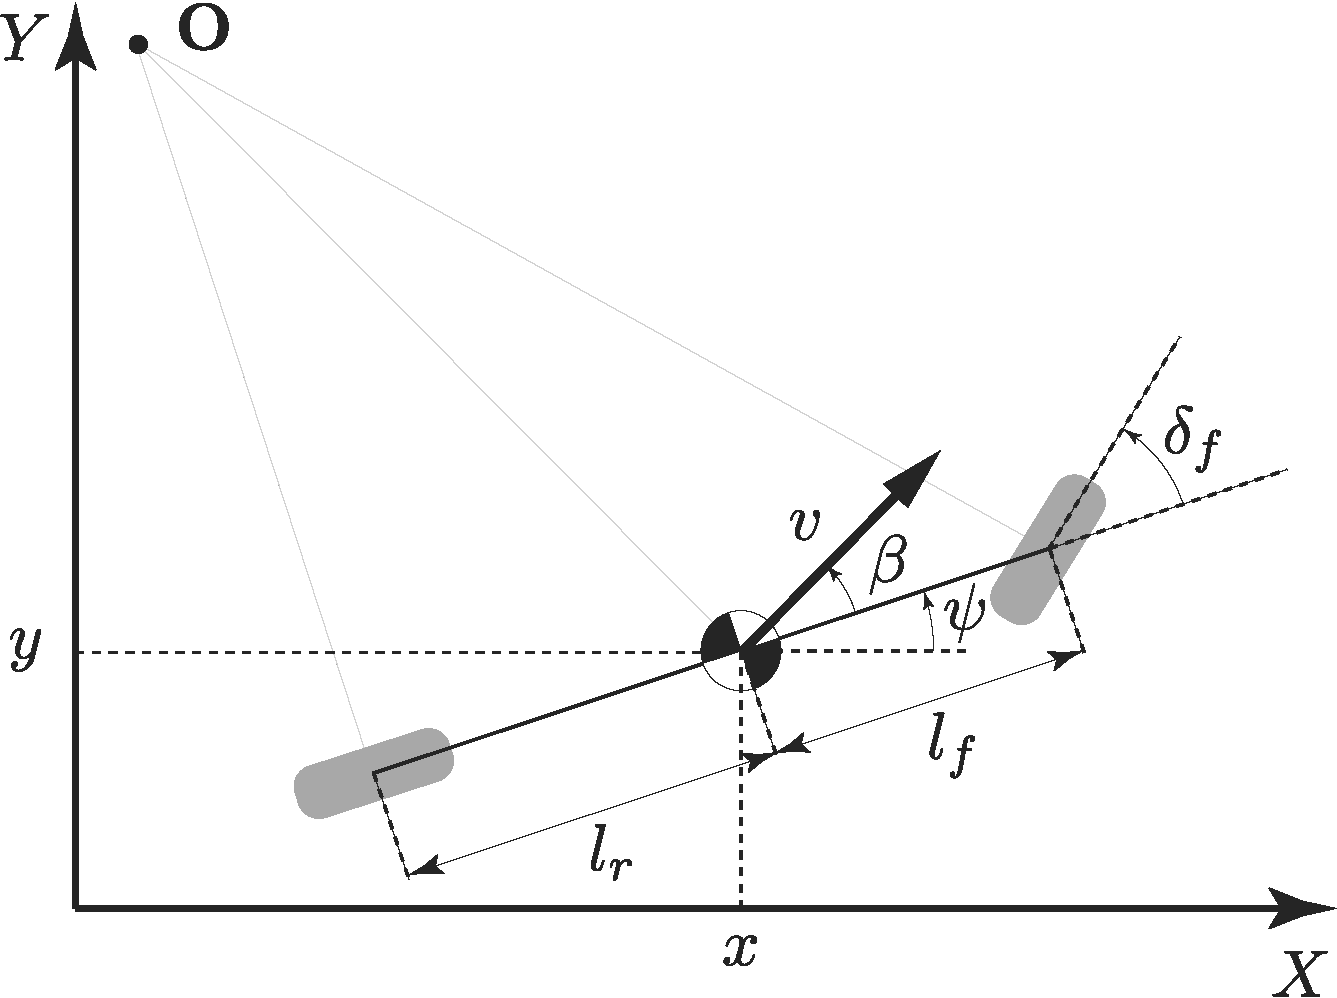 </center>

Consider a simplified kinematic bicycle model :

\begin{align}
\dot{x} &= v \cos(\psi+\beta)\\ 
\dot{y} &= v \sin(\psi+\beta)\\
\dot{\psi} &= \frac{v}{l_r} \sin(\beta)\\
\dot{v} &= a \\
\beta &= \tan^{-1} \left( \frac{l_r}{l_f+l_r}  \tan(\delta_f)\right)
\end{align}

If assume {\delta_f}, {\psi} and {\beta} are small, we can approximize the system as below : 

\begin{align}
\dot{x} &= v \\ 
\dot{y} &= v{\psi} + \frac{l_r}{l_f+l_r}v{\delta_f} \\
\dot{\psi} &= \frac{1}{l_f+l_r}v{\delta_f} \\
\dot{v} &= a \\
\end{align}

Reference : https://ieeexplore.ieee.org/document/8734145/ - Trajectory Planning for Autonomous High-Speed Overtaking in Structured Environments Using Robust MPC

In [51]:
# Car model
# Harvey, Christian, Swastika

#---------------- Parameters ---------------#
### Road Geometry #####
lane_width = 3.5 # [m]
num_lane = 2

### SV (Subject Vehicle) parameter ###
l_f = 1.446 # [m]
l_r = 1.477 # [m]
SV_v_desired = 33.33 # [m/s]


SV_initial_x = 0 # [m]
SV_initial_y = lane_width/2*3 # [m]
SV_initial_psi = 0
SV_initial_v = 32.67 # [m/s]

### LV (Lead Vehicle) parameter ###
# Assume they don't change their lane and run in a constant velocity
num_LV = 3
LV_l_long = 4.1
LV_w_lat = 1.7
wedge_back = 40 # modified 1
wedge_head = 40 # modified 100

# LV_information 
## For showing cacenlling lane change : SV_initial_x - 93.5, vel = 45 for the second LV
LV_initialize  = np.array([[SV_initial_x + -10, SV_initial_x + 100, SV_initial_x + 240],  # x coordinate [m] # modified. 110 220 330. Threshold : 80
                           [lane_width/2, lane_width/2*3, lane_width/2],       # y coordinate [m]
                           [22.5, 22.5, 22.5]])                                           # velocity [m/s]

### Potential Field ###
A_car = 10
Xi = 3
A_lane = 36
sigma = 0.14 * lane_width
alpha = 0.16
Vertice = [[100, 0], [100, num_lane*lane_width], [-60, num_lane*lane_width], [-60, 0]]
U_safe = 10
grid_length = 0.01

### Control Parameters ###
sampling_time = 0.2
N = 10
Q = np.diag([0.0, 0.0, 0.01, 10]) # modified. [1,1] = 0.2
R = np.diag([1.5, 200]) # modified 200
P = ...

### System Parameters ###
# SV_x has no limit
SV_y_lower = 0 # lower limit of y
SV_y_upper = num_lane*lane_width
SV_psi_lower = -0.05
SV_psi_upper = 0.05
SV_v_lower = 22.5
SV_v_upper = SV_v_desired

SV_a_upper = 1.5 # [m/s^2]
SV_a_lower = -1.5
SV_delta_upper = 0.03 # [rad]
SV_delta_lower = -0.03

X_set = pt.Polytope(np.array([[1.0, 0, 0, 0],
                              [-1.0, 0, 0, 0],
                              [0, 1.0, 0, 0],
                               [0, -1.0, 0, 0],
                               [0, 0, 1.0, 0],
                               [0, 0, -1.0, 0],
                               [0, 0, 0, 1.0],
                               [0, 0, 0, -1.0]]), 
                    np.array([[np.Inf],
                              [np.Inf],
                              [SV_y_upper],
                            [-SV_y_lower],
                            [SV_psi_upper],
                            [-SV_psi_lower],
                            [SV_v_upper],
                            [-SV_v_lower]]))

U_set = pt.Polytope(np.array([[1.0, 0],
                              [-1.0, 0],
                              [0, 1.0],
                              [0, -1.0]]), 
                    np.array([[SV_a_upper],
                              [-SV_a_lower],
                              [SV_delta_upper],
                              [-SV_delta_lower]]))

print(X_set)

### Driving mode ###
CRUISE_MODE = 0;
OVERTAKE_MODE = 1;


Single polytope 
  [[ 1.  0.  0.  0.] |    [[   inf]
   [-1.  0.  0.  0.] |     [   inf]
   [ 0.  1.  0.  0.] |     [  7.  ]
   [ 0. -1.  0.  0.] x <=  [  0.  ]
   [ 0.  0.  1.  0.] |     [  0.05]
   [ 0.  0. -1.  0.] |     [  0.05]
   [ 0.  0.  0.  1.] |     [ 33.33]
   [ 0.  0.  0. -1.]]|     [-22.5 ]]



[-10.     1.75]


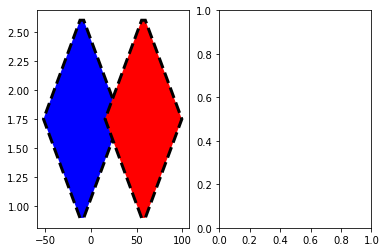

In [20]:
class Subject_vehicle :
  def __init__(self, init_x, init_y, init_psi, l_f = l_f, l_r = l_r, length = LV_l_long, width = LV_w_lat, init_vel = SV_initial_v) :
    self.l_f = l_f
    self.l_r = l_r
    self.state = np.array([init_x, init_y, init_psi, init_vel])
    self.length = length
    self.width = width
    self.A = np.array([[1.0, 0, 0, sampling_time],
                       [0, 1.0, self.state[3]*sampling_time, 0],
                       [0, 0, 1.0, 0],
                       [0, 0, 0, 1]])
    self.B = np.array([[0, 0],
                       [0, self.state[3]*sampling_time / (self.l_f+self.l_r) * self.l_r],
                       [0, self.state[3]*sampling_time / (self.l_f+self.l_r)],
                       [sampling_time, 0]])
    self.lane_thresh = 0.05    # if SV stays 0.8m away from the head_lane, we suppose it successfully changed the lane.
    
    for i in range(num_lane) :
      if self.state[1] > i*lane_width and self.state[1] <= (i+1)*lane_width :
        self.curr_lane = num_lane - i
        self.head_lane = self.curr_lane

  def getState(self) :
    return self.state

  def update_state_approx(self, input) :
    self.state = self.A @ self.state + self.B @ input
    self.set_curr_lane()

  def update_state_Notapprox(self, input) :
    beta = np.arctan( self.l_r / (self.l_f + self.l_r) * np.tan(input[1]))
    self.state += sampling_time * np.array([self.state[3] * np.cos(beta + self.state[2]),
                                            self.state[3] * np.sin(beta + self.state[2]),
                                            self.state[3]/self.l_r*np.sin(beta),
                                            input[0]])
    self.set_curr_lane()
  
  def get_laneInfo(self) :
    return [self.curr_lane, self.head_lane]
  
  def set_curr_lane(self) :
    head_lane_y = lane_width/2 + lane_width*(num_lane - self.head_lane)
    if abs(head_lane_y - self.state[1]) < self.lane_thresh :
      self.curr_lane = self.head_lane

  def set_head_lane(self, target_point) :
    for i in range(num_lane) :
      if target_point[1] >= i*lane_width and target_point[1] < (i+1)*lane_width :
        self.head_lane = num_lane - i
        break


class Lead_vehicle :
  def __init__(self, init_x, init_y, vel, length = LV_l_long, width = LV_w_lat, _wedge_back = wedge_back, _wedge_head = wedge_head) :
    self.pos = np.array([init_x, init_y])
    self.length = length
    self.width = width
    self.vel = vel
    self.wedge_back = _wedge_back
    self.wedge_head = _wedge_head
    self.pos_pred = np.array([self.pos[0] + N*sampling_time*self.vel, self.pos[1]])

  def getPosition(self) :
    return self.pos

  def getPosition_predict(self) :
    return self.pos_pred
  
  def updatePosition(self) :
    self.pos[0] += sampling_time * self.vel
    self.pos_pred[0] = self.pos[0] + N*sampling_time*self.vel

  def getWedgePoints(self) :
    return np.array([[self.pos[0] - self.length/2 - self.wedge_back, self.pos[1]],
                     [self.pos[0] - self.length/2, self.pos[1] + self.width/2],
                     [self.pos[0] + self.length/2, self.pos[1] + self.width/2],
                     [self.pos[0] + self.length/2 + self.wedge_head, self.pos[1]],
                     [self.pos[0] + self.length/2, self.pos[1] - self.width/2],
                     [self.pos[0] - self.length/2, self.pos[1] - self.width/2]])
    
  def getWedgePoints_predict(self) :
    current_WedgePoints = self.getWedgePoints()
    current_WedgePoints[:,0] += N*sampling_time*self.vel
    return current_WedgePoints
  
  def makePolytope(self, vertices) :
    A = np.empty((6,2))
    B = np.empty((6,1))
    idx = 0
    for i in [1,3,4,0] :
      x1, y1, x2, y2 = [vertices[i,0], vertices[i,1], vertices[i-1,0], vertices[i-1,1]]
      a = (y2-y1)/(x2-x1)
      b = y1 - a*x1
      if i in [1,3] :
        A[idx,:] = [-a, 1.0]
        B[idx,:] = [b]
      else :
        A[idx,:] = [a, -1.0]
        B[idx,:] = [-b]
      idx += 1
    A[4:,:] = [[0, 1.0], [0, -1.0]]
    B[4:,:] = [[self.width/2 + self.pos[1]], [self.width/2 - self.pos[1]]]

    return pt.Polytope(A, B)

  def getPolytope(self) :
    vertices = self.getWedgePoints()
    return self.makePolytope(vertices)

  def getPolytope_predict(self) :
    vertices = self.getWedgePoints_predict()
    return self.makePolytope(vertices)

  ###### For Animation ###############
  def getVertice_anim(self, position) :
    vertice_x = np.array([[position[0] + self.length/2, position[0] - self.length/2, position[0] - self.length/2, position[0] + self.length/2]])
    vertice_y = np.array([[position[1] + self.width/2,  position[1] + self.width/2,  position[1] - self.width/2,  position[1] - self.width/2]])
    vertice = np.concatenate((vertice_x.T, vertice_y.T), axis=1)
    return vertice

  def getWedgePoints_anim(self, position) :
    WedgePoints = np.array([[position[0] - self.length/2 - self.wedge_back, position[1]],
                            [position[0] - self.length/2, position[1] + self.width/2],
                            [position[0] + self.length/2, position[1] + self.width/2],
                            [position[0] + self.length/2 + self.wedge_head, position[1]],
                            [position[0] + self.length/2, position[1] - self.width/2],
                            [position[0] - self.length/2, position[1] - self.width/2]])
    return WedgePoints

SV = Subject_vehicle(init_x = SV_initial_x, init_y = SV_initial_y, init_psi = SV_initial_psi)
LV1 = Lead_vehicle(LV_initialize[0,0], LV_initialize[1,0], LV_initialize[2,0])
LV2 = Lead_vehicle(LV_initialize[0,1], LV_initialize[1,1], LV_initialize[2,1])
print(LV1.getPosition())
fig, ax = plt.subplots(1,2)
X = LV1.getPolytope()
X_pred = LV1.getPolytope_predict()
X.plot(ax[0], color='b')
X_pred.plot(ax[0], color='r')
ax[0].autoscale_view()
#ax[0].set_zlim([-10,10])
#ax[0].axis('equal')


In [47]:
# Detect LVs
# Should detect LVs within 100m from SV
# Should know which LV is in front of SV or on the lane to which SV plans to move
def detect_LV(SV, LV_list) :
  x, v = SV.getState()[[0,3]]
  x_pred = x + v * sampling_time * N
  idx_front = -1
  idx_side = -1
  min_x_i = np.inf
  max_x_i_pred = -1

  
  for i in range(len(LV_list)) :
    lane_i = 0

    # get lane information of each LV
    [x_i, y_i] = LV_list[i].getPosition()
    for j in range(num_lane) :
      if y_i >= j*lane_width and y_i < (j+1)*lane_width :
        lane_i = num_lane - j
        break

    # Find out LV in front of SV
    if lane_i == SV.curr_lane :
      if x_i > x and x_i < min_x_i :
        min_x_i = x_i
        idx_front = i

    # Find out LV on the lane to which SV plans to move (All LVs whose predicted position is behind predicted position of SV)
    # In this case, since there are only 2 lanes, just 'else' is enough
    else :
      x_i_pred = LV_list[i].getPosition_predict()[0]
      if x_pred > x_i_pred and x_i_pred > max_x_i_pred :
        max_x_i_pred = x_i_pred
        idx_side = i      
    
  return [idx_front, idx_side]
#-------------------------------------------------------------------------------#

# Reachability set - without accelerating
# with original system and ts=0.1, 20 step : 3m 17s
# with simple system and ts=0.2, 10 step : 1s (erasing acceleration term from the input vector)
# with simple system and ts=0.1, 20 step : 5s

def get_reachable_set(x0, y0, psi0, v0, ts, N) :
  eps_pos = 0.01
  eps = 0.001
  A_sys = np.array([[1.0, 0, 0, ts],
                    [0, 1.0, v0*ts, 0],
                    [0, 0, 1.0, 0],
                    [0, 0, 0, 1.0]])
  '''
  B_sys = np.array([[0, 0],
                    [0, v0*l_r*ts/(l_f+l_r)],
                    [0, v0*ts/(l_f+l_r)],
                    [ts, 0]])
  '''
  B_sys = np.array([[0],
                    [v0*l_r*ts/(l_f+l_r)],
                    [v0*ts/(l_f+l_r)],
                    [0]])
  X = pt.Polytope(np.array([[1.0, 0, 0, 0], 
                            [-1.0, 0, 0, 0],
                            [0, 1.0, 0, 0],
                            [0, -1.0, 0, 0],
                            [0, 0, 1.0, 0],
                            [0, 0, -1.0, 0],
                            [0, 0, 0, 1.0],
                            [0, 0, 0, -1.0]]), 
                  np.array([[x0], 
                            [-x0+2*eps_pos],
                            [y0+eps_pos],
                            [-y0+eps_pos],
                            [psi0+eps],
                            [-psi0+eps],
                            [v0+eps],
                            [-v0+eps]]))
  '''
  U = pt.Polytope(np.array([[1.0, 0], 
                            [-1.0, 0],
                            [0, 1.0],
                            [0, -1.0]]),
                  np.array([[0.0], 
                            [-SV_a_lower],
                            [SV_delta_upper],
                            [-SV_delta_lower]]))
  '''
  U = pt.Polytope(np.array([[1.0],
                            [-1.0]]),
                  np.array([[SV_delta_upper],
                            [-SV_delta_lower]]))
  
  for i in range(N) :
    print(str(i) + 'th successor calculation')
    X = successor(X, A_sys, U, B_sys).intersect(X_set)
  return X

def get_point_in_2D_bbox(reachable_set, test = False) :
  pt_tmp = reachable_set.project([1,2])  # project the reachable set to x-y plane
  pt_tmp = pt_tmp.bounding_box           # pt_tmp = two corner of the bounding box of the projection : left_lower, right_upper
  x = np.arange(pt_tmp[0][0,0], pt_tmp[1][0,0], grid_length)
  
  threshold = 0.001
  if pt_tmp[0][1,0] < threshold :
    pt_tmp[0][1,0] += grid_length
  if pt_tmp[1][1,0] > num_lane*lane_width - threshold :
    pt_tmp[1][1,0] -= grid_length
    
  y = np.arange(pt_tmp[0][1,0], pt_tmp[1][1,0], grid_length)

  # Only for test - return points on large area
  if test :
    x = np.linspace(40, 70, 100)
    y = np.linspace(grid_length, num_lane*lane_width-grid_length, 100)
  ########
  
  xx, yy = np.meshgrid(x, y)
  return xx, yy

##### Potential Funtions - road potential, lane potential, car potential #####

# road potential - a potential function that prevents SV from getting closer to edges of the road
def road_potential(target) :
  road_risk = 0.5*Xi*((1/(target[1]-num_lane*lane_width))**2 + (1/target[1])**2)
  return road_risk

# lane potential - a potential function that forces SV to stay in the middle of the road
def lane_potential(target) :
  lane_risk = 0
  for i in range(num_lane+1) : 
    lane_risk += A_lane * np.exp( -(target[1]-i*lane_width)**2 / (2*(sigma**2)) )
  return lane_risk

# car_potential - a potential function that make SV stay away from LVs.
def car_potential(target, LV, turn_off) :
  if target in LV.getPolytope_predict() :  # modified LV.getPolytope()
    return np.Inf

  if turn_off :
    return 0
  point = LV.getWedgePoints_predict()     # modified LV.getWedgePoints()
  length = np.linalg.norm(target - point[0])
  for i in range(point.shape[0]-1) :
    tmp = np.linalg.norm(target - point[i+1])
    if length > tmp :
      length = tmp

  car_risk = A_car * (np.exp(-alpha*length)) / length 
  return car_risk

# Get risk value based on potential functions. If the return value is lower than U_safe, it's safe
def risk_value(target, _LV1, _LV2=None, _LV3=None, car_potential_off = True) :
  if _LV2 == None :
    return road_potential(target) + lane_potential(target) + car_potential(target, _LV1, car_potential_off)
  if _LV3 == None :
    return road_potential(target) + lane_potential(target) + car_potential(target, _LV1, car_potential_off) + car_potential(target, _LV2, car_potential_off)
  return road_potential(target) + lane_potential(target) + car_potential(target, _LV1, car_potential_off) + car_potential(target, _LV2, car_potential_off) + car_potential(target, _LV3, car_potential_off)
#----------------------------------------------------------------------------#

# Among the points in reachable set, choose a target point using the risk map
def get_target_state(risk_map, initial_x, print_safe_map = False, Subject_vehicle = SV, mode = OVERTAKE_MODE) :
  safe_map = risk_map[:, risk_map[2,:] < U_safe]             # filter the points in risk map that pass safe standard
  
  # If there's no safe point. Obtain safe_map with increased threshold
  '''
  U_tmp = U_safe
  while np.size(safe_map,1) == 0 :
    print('Safe threshold increased')
    U_tmp += 1
    safe_map = risk_map[:, risk_map[2,:] < U_tmp]
  '''
  safe_map = safe_map[:, safe_map[0,:] == np.amax(safe_map[0,:])]           # obtain the farthest safe points in x-direction, which are on the same lane as SV if it's possible

  # If there are points on the same lane as SV's current lane, set safe_map as the set of those points
  tmp = safe_map[:, (safe_map[1,:] > (num_lane - SV.get_laneInfo()[0]) * lane_width) & (safe_map[1,:] < (num_lane - SV.get_laneInfo()[0] + 1) * lane_width)]
  if np.size(tmp,1) is not 0 : 
    safe_map = tmp

  if print_safe_map :
    print('Safe map with the biggest x')
    print(safe_map)

  lowest_risk_point = safe_map[:, np.argmin(safe_map[2,:])]   # choose the safest point among the farthest safe points 
  target_vel = (lowest_risk_point[0] - initial_x) / (sampling_time*N)
  target_psi = 0.0
  target_state = np.array([lowest_risk_point[0], lowest_risk_point[1], target_psi, target_vel, lowest_risk_point[2]])
  # print(target_state)
  SV.set_head_lane(target_state[:2])
  
  return target_state

  #---------------------------------------------------------------------------#


In [ ]:
#### test ####
'''
test = get_reachable_set(SV_initial_x, SV_initial_y, 0.03, SV_initial_v, 0.2, 10)
get_point_in_2D_bbox(test)
X = test.project([1,2])
print(X)

fig, ax = plt.subplots(1,2)
X.plot(ax[0], color='b')
ax[0].legend(['X', 'X & Pre(X, W)'])
ax[0].autoscale_view()
ax[0].axis('equal')


X = X.bounding_box
print(X)
print(X[0][1,0])
for a,b in X :
  print("corner : x : " + str(a[0]) + " y : " + str(b[0]))
  '''
##########
# 6.666  ]
#  [ 1.75     1.79245]
#  [ 0.       0.02874]
#  [33.33    33.48603
SV = Subject_vehicle(init_x = SV_initial_x, init_y = SV_initial_y, init_psi = SV_initial_psi)
LV1 = Lead_vehicle(LV_initialize[0,0], LV_initialize[1,0], LV_initialize[2,0])
LV2 = Lead_vehicle(LV_initialize[0,1], LV_initialize[1,1], LV_initialize[2,1])

U_safe = np.Inf
xx, yy = get_point_in_2D_bbox(get_reachable_set(SV.getState()[0], SV.getState()[1], SV.getState()[2], SV.getState()[3], 0.2, 10), False)
risk_map = np.zeros((3,xx.size))
index = 0
for i in range(xx.shape[0]) :
  for j in range(xx.shape[1]) :
    risk_map[0,index] = xx[i,j]
    risk_map[1,index] = yy[i,j]
    risk_map[2,index] = risk_value(np.array([xx[i,j], yy[i,j]]), LV1)
    index += 1

test_target_point = get_target_state(risk_map, SV.getState()[0])
risk_map = risk_map[:, risk_map[2,:]<U_safe]

ax = plt.axes(projection='3d')
ax.scatter3D(risk_map[0,:], risk_map[1,:], risk_map[2,:], alpha = 0.1, c = risk_map[0,:] + risk_map[1,:] +risk_map[2,:], cmap = plt.get_cmap('hsv'))
ax.scatter3D(test_target_point[0], test_target_point[1], test_target_point[4])
ax.set_zlim(0, 150);
print('SV state : ')
print(SV.getState())
print('LV position - LV1 : ')
print(LV1.getPosition())
print('LV2 : ')
print(LV2.getPosition())
print(test_target_point)


ValueError: ignored

In [48]:
# Solve CFTOC for car
from __future__ import division

def solve_cftoc_onlyCar(A, B, P, Q, R, N, x0, X_set, U_set, bf, Af, SV, LV_info, LV_list, reachable_set, add_extra_constraint) :
  model = pyo.ConcreteModel()
  model.A = A
  model.B = B
  model.P = P
  model.Q = Q
  model.R = R
  model.N = N
  model.Af = Af
  model.SV = SV
  model.LV_front = LV_list[LV_info[0]]  if LV_info[0] != -1 else None
  model.LV_side = LV_list[LV_info[1]]   if LV_info[1] != -1 else None
  model.X_set = X_set
  model.U_set = U_set
  
  model.nx = np.size(A,1)
  model.nu = np.size(B,1)

  model.tidx = pyo.Set(initialize = range(0,N+1))
  model.xidx = pyo.Set(initialize = range(0, model.nx))
  model.uidx = pyo.Set(initialize = range(0, model.nu))

  model.x = pyo.Var(model.xidx, model.tidx)
  model.u = pyo.Var(model.uidx, model.tidx)
  model.target_state = bf
  model.strict_terminalConst = True

  # test
  model.target_state_stage = model.target_state
  model.target_state_stage[2] = (model.target_state[1] - x0[1])/(model.target_state[0] - x0[0])

  eps = 0.001

  def Objective_func_rule(model) :
    costP = 0
    costQ = 0
    costR = 0

    for t in model.tidx :
      for i in model.xidx :
        if t < model.N :
          costQ += (model.x[i,t] - model.target_state[i]) * model.Q[i,i] * (model.x[i,t] - model.target_state[i])

    for t in model.tidx :
      for i in model.uidx :
        if t < model.N :
          costR += model.u[i,t] * model.R[i,i] * model.u[i,t]

    for i in model.xidx :
      for j in model.xidx :
        costP += (model.x[i,model.N] - model.target_state[i]) * model.P[i,j] * (model.x[j,model.N] - model.target_state[i])

    return costP + costQ + costR

  model.cost = pyo.Objective(rule = Objective_func_rule, sense = pyo.minimize)

  def Equality_constraint_rule(model, i, t) :
    return (sum(model.A[i,j] * model.x[j,t] for j in model.xidx) + sum(model.B[i,j] * model.u[j,t] for j in model.uidx)) - model.x[i,t+1] == 0 if t<model.N else pyo.Constraint.Skip

  def Initial_constraint_rule(model, i) :
    return model.x[i,0] - x0[i] == 0

  # When Af == [] & bf != [], x_terminal_value == x_target and y_terminal_value == y_target. This constraint may be modified 
  def Terminal_constraint_rule(model, i) :
    if model.Af == [] :
      if model.target_state == [] :
        return pyo.Constraint.Skip
      else :
        model.strict_terminalConst = True
        return model.x[i,N] - model.target_state[i] == 0 if i<2 else pyo.Constraint.Skip   # This may be modified
    else :
      # When the terminal constraint is like target_x-eps <= x <= target_x+eps, target_y-eps <= y <= target_y+eps, ...
      model.strict_terminalConst = False
      if np.size(model.Af, 1) == 2 :
        # [x_eps, y_eps, psi_eps, v_eps] = [0.1, 0.1, 0.01, 0.01]
        # model.target_state = np.array([bf[0] + x_eps, -bf[0] + x_eps, bf[1] + y_eps, -bf[1] + y_eps, 
        #                                bf[2] + psi_eps, -bf[2] + psi_eps, bf[3] + v_eps, -bf[3] + v_eps])
        [x_eps, y_eps] = [0.1, 0.1]
        model.target_state = np.array([bf[0] + x_eps, -bf[0] + x_eps, bf[1] + y_eps, -bf[1] + y_eps])
        return sum(model.Af[i,j] * model.x[j,N] for j in range(0,2)) - model.target_state[i] <= 0
      else :
        return sum(model.Af[i,j] * model.x[j,N] for j in range(0,2)) - model.target_state[i] <= 0

  def Inequality_constraint_rule_state(model, i, t) :
    return sum(model.X_set.A[i,j] * model.x[j,t] for j in model.xidx) - model.X_set.b[i] <= 0

  def Inequality_constraint_rule_input(model, i, t) :
    return sum(model.U_set.A[i,j] * model.u[j,t] for j in model.uidx) - model.U_set.b[i] <= 0

  model.equalityConst = pyo.Constraint(model.xidx, model.tidx, rule = Equality_constraint_rule)
  model.initConst = pyo.Constraint(model.xidx, rule = Initial_constraint_rule) 
  
  if model.strict_terminalConst :
    model.terminalConst = pyo.Constraint(model.xidx, rule = Terminal_constraint_rule)
  else :
    model.terminalConst = pyo.Constraint(range(0,4), rule = Terminal_constraint_rule)
 
  # model.StateConst = pyo.Constraint(model.xidx, model.tidx, rule = Inequality_constraint_rule_state)
  model.InputConst = pyo.Constraint(model.uidx, model.tidx, rule = Inequality_constraint_rule_input)
  model.StateConst1 = pyo.Constraint(model.tidx, rule=lambda model, t: model.x[1,t] <= SV_y_upper )
  model.StateConst2 = pyo.Constraint(model.tidx, rule=lambda model, t: model.x[2,t] <= SV_psi_upper if t>0 else pyo.Constraint.Skip)
  model.StateConst3 = pyo.Constraint(model.tidx, rule=lambda model, t: model.x[3,t] <= SV_v_upper)
  model.StateConst4 = pyo.Constraint(model.tidx, rule=lambda model, t: model.x[1,t] >= SV_y_lower)
  model.StateConst5 = pyo.Constraint(model.tidx, rule=lambda model, t: model.x[2,t] >= SV_psi_lower if t>0 else pyo.Constraint.Skip)
  model.StateConst6 = pyo.Constraint(model.tidx, rule=lambda model, t: model.x[3,t] >= SV_v_lower)
  

  # For debug
  [front_x1, front_y1, front_x2, front_y2, side_x1, side_y1, side_x2, side_y2] = [0,0,1,0,0,0,1,0]
  # When the heading line and the current line are different 
  if model.SV.get_laneInfo()[0] != model.SV.get_laneInfo()[1] and add_extra_constraint :
    print('Move from lane', model.SV.get_laneInfo()[0], 'to', model.SV.get_laneInfo()[1], '. LV info : ', LV_info[0], ' ', LV_info[1])
    # When SV heads to the second lane from the first lane
    if model.SV.get_laneInfo()[0] == 1 :
      if(model.LV_front != None) :
        [front_x1, front_y1] = model.LV_front.getWedgePoints()[0,:]
        [front_x2, front_y2] = model.LV_front.getWedgePoints()[5,:]
        
        def Inequality_extraConstraint_rule_state_front(model, t) :
          return model.x[1,t] - front_y1 - ((front_y2-front_y1)/(front_x2-front_x1))*(model.x[0,t] - front_x1) <= 0
        model.StateConst7 = pyo.Constraint(model.tidx, rule=Inequality_extraConstraint_rule_state_front)
     
      if(model.LV_side != None) :
        [side_x1, side_y1]   = model.LV_side.getWedgePoints()[2,:]
        [side_x2, side_y2]   = model.LV_side.getWedgePoints()[3,:]

        def Inequality_extraConstraint_rule_state_side(model, t) :
          return -model.x[1,t] + side_y1 + ((side_y2 -side_y1 )/(side_x2 -side_x1 ))*(model.x[0,t] - side_x1 ) <= 0
        model.StateConst8 = pyo.Constraint(model.tidx, rule=Inequality_extraConstraint_rule_state_side)
    
    # When SV heads to the first lane from the second lane
    else :
      if(model.LV_front != None) :
        [front_x1, front_y1] = model.LV_front.getWedgePoints()[0,:]
        [front_x2, front_y2] = model.LV_front.getWedgePoints()[1,:]

        def Inequality_extraConstraint_rule_state_front(model, t) :
          return -model.x[1,t] + front_y1 + ((front_y2-front_y1)/(front_x2-front_x1))*(model.x[0,t] - front_x1) <= 0
        model.StateConst7 = pyo.Constraint(model.tidx, rule=Inequality_extraConstraint_rule_state_front)

      if(model.LV_side != None) :
        print('bug check')
        [side_x1, side_y1]   = model.LV_side.getWedgePoints()[3,:]
        [side_x2, side_y2]   = model.LV_side.getWedgePoints()[4,:]

        def Inequality_extraConstraint_rule_state_side(model, t) :
          return model.x[1,t] - side_y1 - ((side_y2 -side_y1 )/(side_x2 -side_x1 ))*(model.x[0,t] - side_x1 ) <= 0
        model.StateConst8 = pyo.Constraint(model.tidx, rule=Inequality_extraConstraint_rule_state_side)
    

  # print(model.StateConst)
  # if model.SV.get_laneInfo()[0] == 2 and model.SV.get_laneInfo()[1] == 1 :
  #   model.display()
  solver = pyo.SolverFactory('ipopt')
  results = solver.solve(model)
  # results_write = results.write()

  if results.solver.termination_condition == pyo.TerminationCondition.optimal :
    feas = True
  else :
    feas = False
    model.display()
  
  xOpt = np.asarray([[pyo.value(model.x[i,t]) for t in model.tidx] for i in model.xidx])
  uOpt = np.asarray([[pyo.value(model.u[i,t]) for t in model.tidx if t<model.N] for i in model.uidx])
  JOpt = model.cost()

  wedge_LV1 = LV_list[0].getWedgePoints()
  wedge_LV1_predicted = LV_list[0].getWedgePoints_predict();
  wedge_LV2 = LV_list[1].getWedgePoints()
  wedge_LV2_predicted = LV_list[1].getWedgePoints_predict();

  fig, ax = plt.subplots(1,1,figsize=(9,6))
  # actual = plt.plot(xOpt[0,:], xOpt[1,:], 'ko-')
  ax.plot(xOpt[0,:], xOpt[1,:], 'y*--', linewidth=1)
  ax.set_xlabel('x')
  ax.set_ylabel('y')
  ax.set_title('State Trajectory')
  ax.fill(wedge_LV1[:,0], wedge_LV1[:,1], alpha = 0.2, c = 'g')
  ax.fill(wedge_LV2[:,0], wedge_LV2[:,1], alpha = 0.2, c = 'g')
  ax.fill(wedge_LV1_predicted[:,0], wedge_LV1_predicted[:,1], alpha = 0.2, c = 'r')
  ax.fill(wedge_LV2_predicted[:,0], wedge_LV2_predicted[:,1], alpha = 0.2, c = 'r')

  reachable_set.plot(ax)
  plt.show()
  tmp_float = np.zeros((2, N+1))
  tmp_bool = np.zeros((2, N+1), dtype=bool)
  
  print('SV Lane Info : ', SV.get_laneInfo())
  print('LV info : ', LV_info)
  if model.SV.get_laneInfo()[0] != model.SV.get_laneInfo()[1] :
    for i in model.tidx :
      tmp_front = -xOpt[1,i] + front_y1 + ((front_y2-front_y1)/(front_x2-front_x1))*(xOpt[0,i] - front_x1)
      tmp_side = xOpt[1,i] - side_y1 - ((side_y2 -side_y1 )/(side_x2 -side_x1 ))*(xOpt[0,i] - side_x1 )
      tmp_float[0,i] = tmp_front
      tmp_float[1,i] = tmp_side
      tmp_bool[0,i] = tmp_front <= 0
      tmp_bool[1,i] = tmp_side <= 0

    print(tmp_float)
    print(tmp_bool)

  return [feas, xOpt, uOpt, JOpt]

## Example problem from Lab8
# A = np.array([[1, 1],
#                [0, 1]])
# B = np.array([[0],
#               [1]])
# Q = np.eye(2)
# R = 10*np.array([1]).reshape(1,1)
# P = Q
# N = 3
# xL = -5
# xU = 5
# uL = -0.5
# uU = 0.5
# x0 = np.array([-4.5, 2])
# bf = []
# Af = []

# [feas, xOpt, uOpt, JOpt] = solve_cftoc(A, B, P, Q, R, N, x0, xL, xU, uL, uU, bf, Af)


0th successor calculation
1th successor calculation
2th successor calculation
3th successor calculation
4th successor calculation
5th successor calculation
6th successor calculation
7th successor calculation
8th successor calculation
9th successor calculation
10th successor calculation
11th successor calculation
12th successor calculation
13th successor calculation
14th successor calculation
[[  97.987     97.997     98.007   ...   97.987     97.997     98.007  ]
 [   0.58729    0.58729    0.58729 ...    6.98729    6.98729    6.98729]
 [  21.93883   21.93883   21.93883 ... 9325.7937  9325.7937  9325.7937 ]]
risk value :  0.6458622757919156


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:68: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


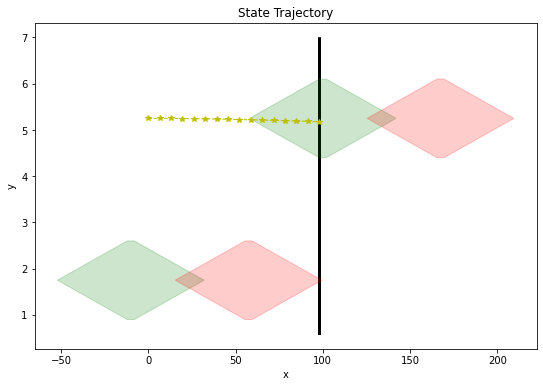

SV Lane Info :  [1, 1]
LV info :  [1, 0]
0 th step ended
---------------------------------------------------------------------
0th successor calculation
1th successor calculation
2th successor calculation
3th successor calculation
4th successor calculation
5th successor calculation
6th successor calculation
7th successor calculation
8th successor calculation
9th successor calculation
10th successor calculation
11th successor calculation
12th successor calculation
13th successor calculation
14th successor calculation
[[ 104.51979  104.52979  104.53979 ...  104.51979  104.52979  104.53979]
 [   0.58635    0.58635    0.58635 ...    6.98635    6.98635    6.98635]
 [  21.9934    21.9934    21.9934  ... 8084.86087 8084.86087 8084.86087]]
risk value :  0.6458408650734979


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:68: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


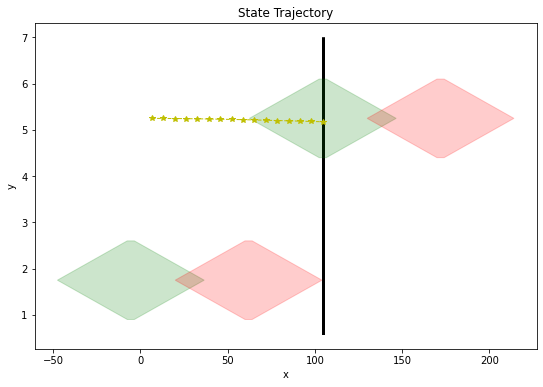

SV Lane Info :  [1, 1]
LV info :  [1, 0]
1 th step ended
---------------------------------------------------------------------
0th successor calculation
1th successor calculation
2th successor calculation
3th successor calculation
4th successor calculation
5th successor calculation
6th successor calculation
7th successor calculation
8th successor calculation
9th successor calculation
10th successor calculation
11th successor calculation
12th successor calculation
13th successor calculation
14th successor calculation
[[ 111.0525   111.0625   111.0725  ...  111.0525   111.0625   111.0725 ]
 [   0.5846     0.5846     0.5846  ...    6.9846     6.9846     6.9846 ]
 [  22.09471   22.09471   22.09471 ... 6360.75644 6360.75644 6360.75644]]
risk value :  0.645818494374137


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:68: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


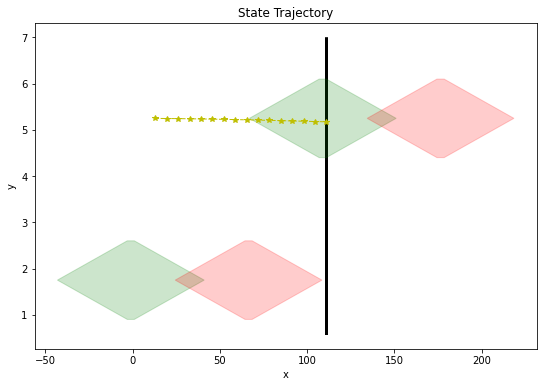

SV Lane Info :  [1, 1]
LV info :  [1, 0]
2 th step ended
---------------------------------------------------------------------
0th successor calculation
1th successor calculation
2th successor calculation
3th successor calculation
4th successor calculation
5th successor calculation
6th successor calculation
7th successor calculation
8th successor calculation
9th successor calculation
10th successor calculation
11th successor calculation
12th successor calculation
13th successor calculation
14th successor calculation
[[ 117.58512  117.59512  117.60512 ...  117.58512  117.59512  117.60512]
 [   0.58221    0.58221    0.58221 ...    6.98221    6.98221    6.98221]
 [  22.23396   22.23396   22.23396 ... 4773.07191 4773.07191 4773.07191]]
risk value :  0.6458243523805658


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:68: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


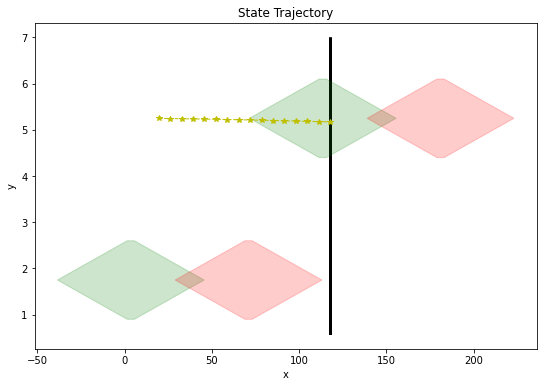

SV Lane Info :  [1, 1]
LV info :  [1, 0]
3 th step ended
---------------------------------------------------------------------
0th successor calculation
1th successor calculation
2th successor calculation
3th successor calculation
4th successor calculation
5th successor calculation
6th successor calculation
7th successor calculation
8th successor calculation
9th successor calculation
10th successor calculation
11th successor calculation
12th successor calculation
13th successor calculation
14th successor calculation
[[  124.11767   124.12767   124.13767 ...   124.11767   124.12767
    124.13767]
 [    0.57929     0.57929     0.57929 ...     6.98929     6.98929
      6.98929]
 [   22.40423    22.40423    22.40423 ... 13118.20811 13118.20811
  13118.20811]]
risk value :  0.645888587781029


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:68: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


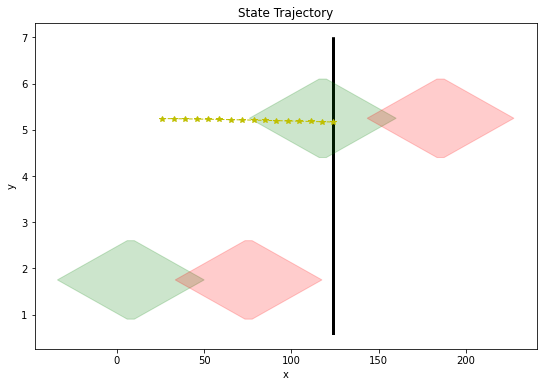

SV Lane Info :  [1, 1]
LV info :  [1, 0]
4 th step ended
---------------------------------------------------------------------
0th successor calculation
1th successor calculation
2th successor calculation
3th successor calculation
4th successor calculation
5th successor calculation
6th successor calculation
7th successor calculation
8th successor calculation
9th successor calculation
10th successor calculation
11th successor calculation
12th successor calculation
13th successor calculation
14th successor calculation
[[ 130.65013  130.66013  130.67013 ...  130.65013  130.66013  130.67013]
 [   0.57596    0.57596    0.57596 ...    6.98596    6.98596    6.98596]
 [  22.59995   22.59995   22.59995 ... 7648.44336 7648.44336 7648.44336]]
risk value :  0.6458339987366403


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:68: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


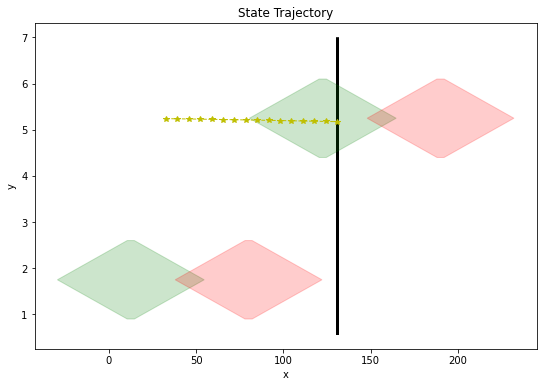

SV Lane Info :  [1, 1]
LV info :  [1, 0]
5 th step ended
---------------------------------------------------------------------
0th successor calculation
1th successor calculation
2th successor calculation
3th successor calculation
4th successor calculation
5th successor calculation
6th successor calculation
7th successor calculation
8th successor calculation
9th successor calculation
10th successor calculation
11th successor calculation
12th successor calculation
13th successor calculation
14th successor calculation
[[ 137.18252  137.19252  137.20252 ...  137.18252  137.19252  137.20252]
 [   0.57244    0.57244    0.57244 ...    6.98244    6.98244    6.98244]
 [  22.80854   22.80854   22.80854 ... 4898.91688 4898.91688 4898.91688]]
risk value :  0.6458219375808898


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:68: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


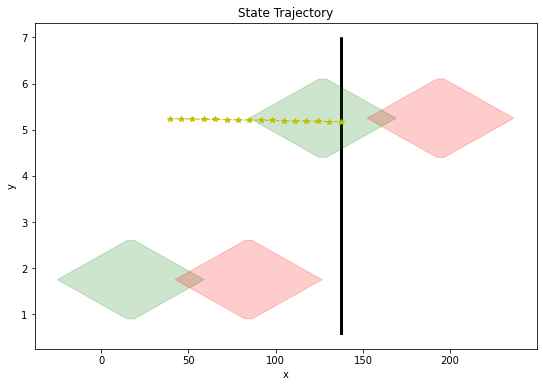

SV Lane Info :  [1, 1]
LV info :  [1, 0]
6 th step ended
---------------------------------------------------------------------
0th successor calculation
1th successor calculation
2th successor calculation
3th successor calculation
4th successor calculation
5th successor calculation
6th successor calculation
7th successor calculation
8th successor calculation
9th successor calculation
10th successor calculation
11th successor calculation
12th successor calculation
13th successor calculation
14th successor calculation
[[  143.71482   143.72482   143.73482 ...   143.71482   143.72482
    143.73482]
 [    0.56875     0.56875     0.56875 ...     6.98875     6.98875
      6.98875]
 [   23.02791    23.02791    23.02791 ... 11897.11996 11897.11996
  11897.11996]]
risk value :  0.6459073204920094


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:68: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


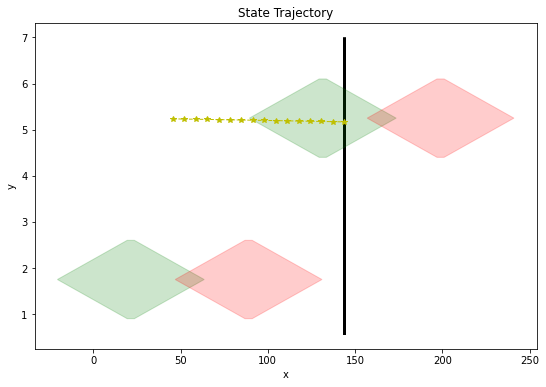

SV Lane Info :  [1, 1]
LV info :  [1, 0]
7 th step ended
---------------------------------------------------------------------
0th successor calculation
1th successor calculation
2th successor calculation
3th successor calculation
4th successor calculation
5th successor calculation
6th successor calculation
7th successor calculation
8th successor calculation
9th successor calculation
10th successor calculation
11th successor calculation
12th successor calculation
13th successor calculation
14th successor calculation
[[ 150.24704  150.25704  150.26704 ...  150.24704  150.25704  150.26704]
 [   0.56495    0.56495    0.56495 ...    6.98495    6.98495    6.98495]
 [  23.25635   23.25635   23.25635 ... 6655.15267 6655.15267 6655.15267]]
risk value :  0.6458211417403116


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:68: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


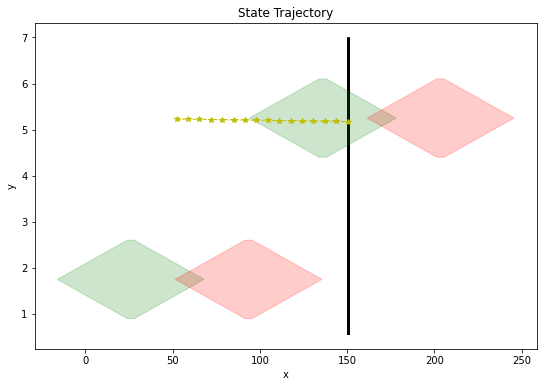

SV Lane Info :  [1, 1]
LV info :  [1, 0]
8 th step ended
---------------------------------------------------------------------
0th successor calculation
1th successor calculation
2th successor calculation
3th successor calculation
4th successor calculation
5th successor calculation
6th successor calculation
7th successor calculation
8th successor calculation
9th successor calculation
10th successor calculation
11th successor calculation
12th successor calculation
13th successor calculation
14th successor calculation
[[ 156.77918  156.78918  156.79918 ...  156.77918  156.78918  156.79918]
 [   0.56118    0.56118    0.56118 ...    6.98118    6.98118    6.98118]
 [  23.48417   23.48417   23.48417 ... 4269.01249 4269.01249 4269.01249]]
risk value :  0.645839879045786


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:68: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


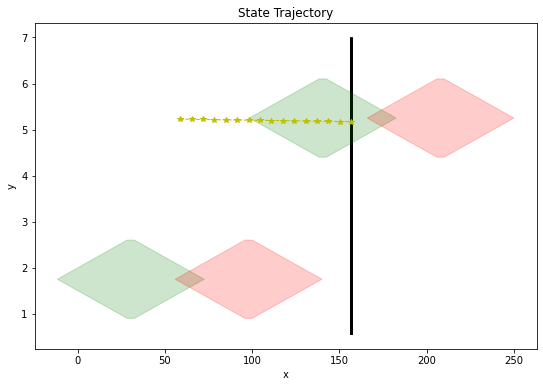

SV Lane Info :  [1, 1]
LV info :  [1, 0]
9 th step ended
---------------------------------------------------------------------
0th successor calculation
1th successor calculation
2th successor calculation
3th successor calculation
4th successor calculation
5th successor calculation
6th successor calculation
7th successor calculation
8th successor calculation
9th successor calculation
10th successor calculation
11th successor calculation
12th successor calculation
13th successor calculation
14th successor calculation
[[ 163.31124  163.32124  163.33124 ...  163.31124  163.32124  163.33124]
 [   0.55744    0.55744    0.55744 ...    6.98744    6.98744    6.98744]
 [  23.71174   23.71174   23.71174 ... 9538.32784 9538.32784 9538.32784]]
risk value :  0.6458660845523505


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:68: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


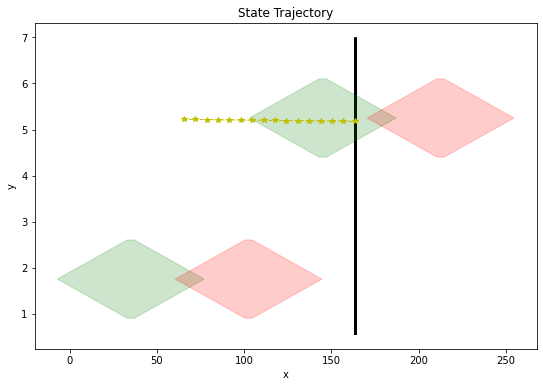

SV Lane Info :  [1, 1]
LV info :  [1, 0]
10 th step ended
---------------------------------------------------------------------
0th successor calculation
1th successor calculation
2th successor calculation
3th successor calculation
4th successor calculation
5th successor calculation
6th successor calculation
7th successor calculation
8th successor calculation
9th successor calculation
10th successor calculation
11th successor calculation
12th successor calculation
13th successor calculation
14th successor calculation
[[ 169.84322  169.85322  169.86322 ...  169.84322  169.85322  169.86322]
 [   0.55386    0.55386    0.55386 ...    6.98386    6.98386    6.98386]
 [  23.93089   23.93089   23.93089 ... 5793.82437 5793.82437 5793.82437]]
risk value :  0.645815794429167


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:68: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


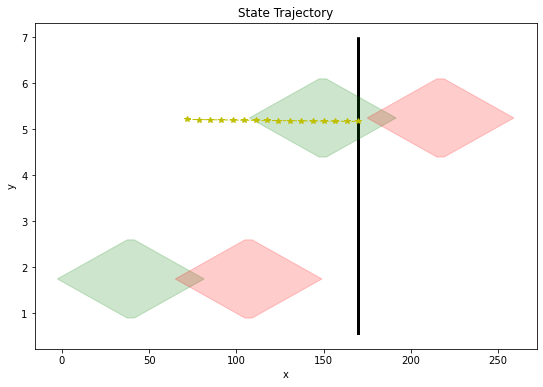

SV Lane Info :  [1, 1]
LV info :  [1, 0]
11 th step ended
---------------------------------------------------------------------
0th successor calculation
1th successor calculation
2th successor calculation
3th successor calculation
4th successor calculation
5th successor calculation
6th successor calculation
7th successor calculation
8th successor calculation
9th successor calculation
10th successor calculation
11th successor calculation
12th successor calculation
13th successor calculation
14th successor calculation
[[ 176.37512  176.38512  176.39512 ...  176.37512  176.38512  176.39512]
 [   0.55042    0.55042    0.55042 ...    6.98042    6.98042    6.98042]
 [  24.14337   24.14337   24.14337 ... 3946.68907 3946.68907 3946.68907]]
risk value :  0.6458563792483929


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:68: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


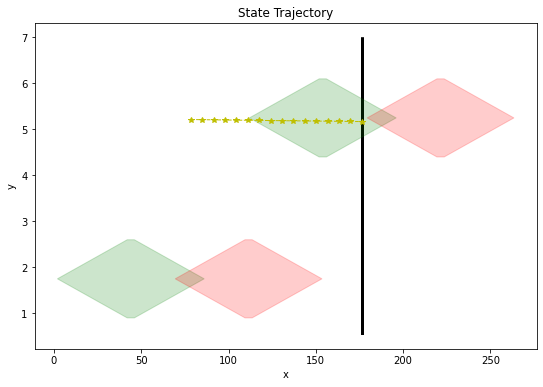

SV Lane Info :  [1, 1]
LV info :  [1, 0]
12 th step ended
---------------------------------------------------------------------
0th successor calculation
1th successor calculation
2th successor calculation
3th successor calculation
4th successor calculation
5th successor calculation
6th successor calculation
7th successor calculation
8th successor calculation
9th successor calculation
10th successor calculation
11th successor calculation
12th successor calculation
13th successor calculation
14th successor calculation
[[ 182.90694  182.91694  182.92694 ...  182.90694  182.91694  182.92694]
 [   0.54708    0.54708    0.54708 ...    6.98708    6.98708    6.98708]
 [  24.35059   24.35059   24.35059 ... 9019.12106 9019.12106 9019.12106]]
risk value :  0.6458568253851996


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:68: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


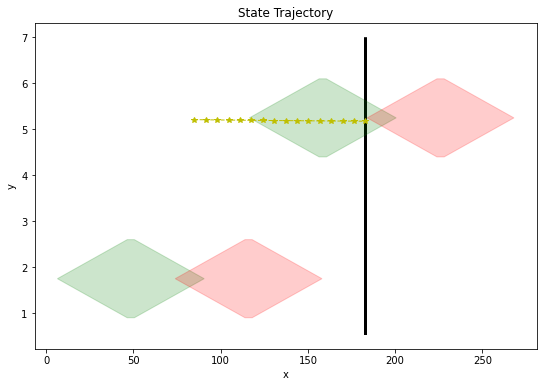

SV Lane Info :  [1, 1]
LV info :  [1, 0]
13 th step ended
---------------------------------------------------------------------
0th successor calculation
1th successor calculation
2th successor calculation
3th successor calculation
4th successor calculation
5th successor calculation
6th successor calculation
7th successor calculation
8th successor calculation
9th successor calculation
10th successor calculation
11th successor calculation
12th successor calculation
13th successor calculation
14th successor calculation
[[ 189.43868  189.44868  189.45868 ...  189.43868  189.44868  189.45868]
 [   0.54397    0.54397    0.54397 ...    6.98397    6.98397    6.98397]
 [  24.54508   24.54508   24.54508 ... 5869.90227 5869.90227 5869.90227]]
risk value :  0.6458159328502788


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:68: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


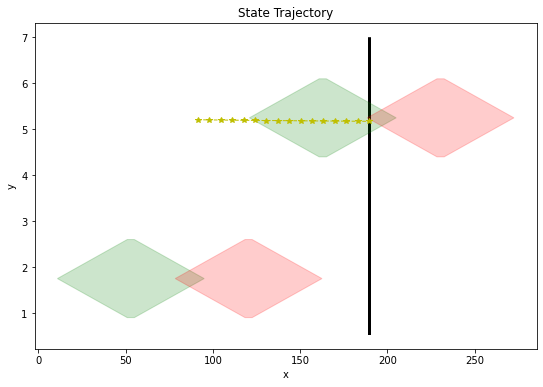

SV Lane Info :  [1, 1]
LV info :  [1, 0]
14 th step ended
---------------------------------------------------------------------
0th successor calculation
1th successor calculation
2th successor calculation
3th successor calculation
4th successor calculation
5th successor calculation
6th successor calculation
7th successor calculation
8th successor calculation
9th successor calculation
10th successor calculation
11th successor calculation
12th successor calculation
13th successor calculation
14th successor calculation
[[ 195.97034  195.98034  195.99034 ...  195.97034  195.98034  195.99034]
 [   0.54103    0.54103    0.54103 ...    6.98103    6.98103    6.98103]
 [  24.72933   24.72933   24.72933 ... 4205.84283 4205.84283 4205.84283]]
risk value :  0.6458426363665286


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:68: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


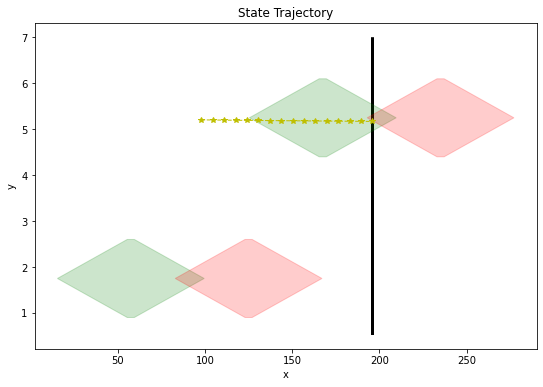

SV Lane Info :  [1, 1]
LV info :  [1, 0]
15 th step ended
---------------------------------------------------------------------
0th successor calculation
1th successor calculation
2th successor calculation
3th successor calculation
4th successor calculation
5th successor calculation
6th successor calculation
7th successor calculation
8th successor calculation
9th successor calculation
10th successor calculation
11th successor calculation
12th successor calculation
13th successor calculation
14th successor calculation
[[  202.50191   202.51191   202.52191 ...   202.50191   202.51191
    202.52191]
 [    0.53825     0.53825     0.53825 ...     6.98825     6.98825
      6.98825]
 [   24.90534    24.90534    24.90534 ... 10897.84895 10897.84895
  10897.84895]]
risk value :  0.6505610005671352


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:68: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


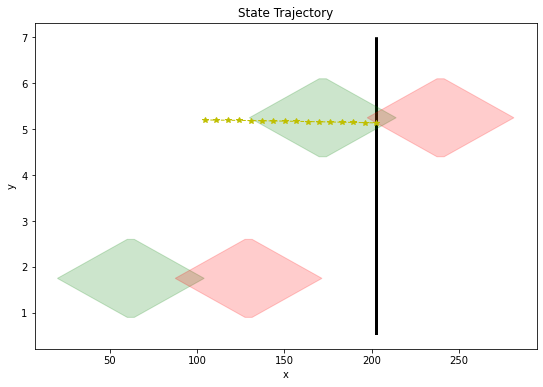

SV Lane Info :  [1, 1]
LV info :  [1, 0]
16 th step ended
---------------------------------------------------------------------
0th successor calculation
1th successor calculation
2th successor calculation
3th successor calculation
4th successor calculation
5th successor calculation
6th successor calculation
7th successor calculation
8th successor calculation
9th successor calculation
10th successor calculation
11th successor calculation
12th successor calculation
13th successor calculation
14th successor calculation
[[ 209.03341  209.04341  209.05341 ...  209.03341  209.04341  209.05341]
 [   0.53517    0.53517    0.53517 ...    6.98517    6.98517    6.98517]
 [  25.10106   25.10106   25.10106 ... 6855.76819 6855.76819 6855.76819]]
risk value :  0.6458201604813875
Move from lane 1 to 2 . LV info :  1   0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:68: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


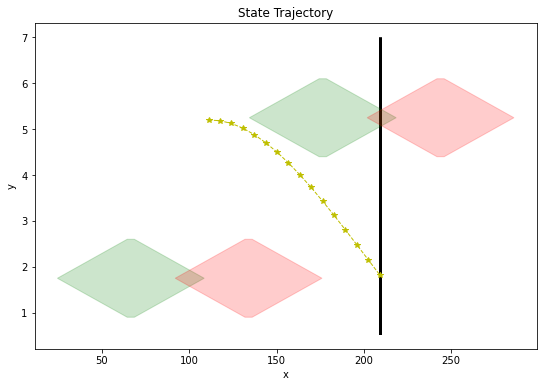

SV Lane Info :  [1, 2]
LV info :  [1, 0]
[[0.54755 0.42245 0.34332 0.3065  0.30829 0.34505 0.41311 0.50884 0.62859
  0.76873 0.92563 1.09567 1.27524 1.4607  1.64858 1.83608]
 [3.50283 3.62793 3.70705 3.74388 3.74208 3.70533 3.63726 3.54154 3.42179
  3.28165 3.12475 2.9547  2.77514 2.58967 2.4018  2.21429]]
[[False False False False False False False False False False False False
  False False False False]
 [False False False False False False False False False False False False
  False False False False]]
17 th step ended
---------------------------------------------------------------------
0th successor calculation
1th successor calculation
2th successor calculation
3th successor calculation
4th successor calculation
5th successor calculation
6th successor calculation
7th successor calculation
8th successor calculation
9th successor calculation
10th successor calculation
11th successor calculation
12th successor calculation
13th successor calculation
14th successor calculation
[[ 215.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:68: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


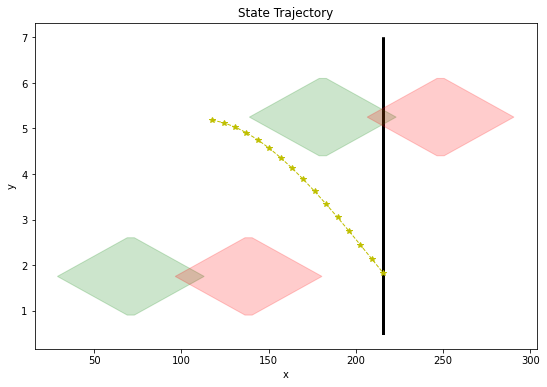

SV Lane Info :  [1, 2]
LV info :  [1, 0]
[[0.51807 0.43731 0.39189 0.3791  0.39623 0.44059 0.5095  0.60027 0.71024
  0.83674 0.97709 1.12864 1.28873 1.45471 1.62391 1.79369]
 [3.53231 3.61306 3.65848 3.67128 3.65415 3.60979 3.54088 3.4501  3.34013
  3.21364 3.07329 2.92173 2.76164 2.59567 2.42646 2.25668]]
[[False False False False False False False False False False False False
  False False False False]
 [False False False False False False False False False False False False
  False False False False]]
18 th step ended
---------------------------------------------------------------------
0th successor calculation
1th successor calculation
2th successor calculation
3th successor calculation
4th successor calculation
5th successor calculation
6th successor calculation
7th successor calculation
8th successor calculation
9th successor calculation
10th successor calculation
11th successor calculation
12th successor calculation
13th successor calculation
14th successor calculation
[[  222

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:68: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


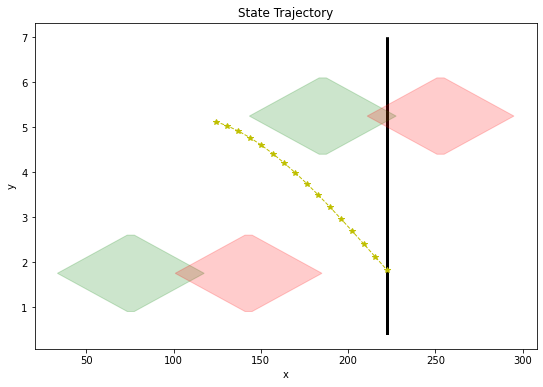

SV Lane Info :  [1, 2]
LV info :  [1, 0]
[[0.53293 0.48624 0.46675 0.47238 0.50103 0.55065 0.61916 0.70451 0.80462
  0.91746 1.04097 1.1731  1.3118  1.45503 1.60074 1.7469 ]
 [3.51744 3.56413 3.58362 3.578   3.54934 3.49973 3.43121 3.34587 3.24575
  3.13291 3.00941 2.87728 2.73858 2.59535 2.44963 2.30347]]
[[False False False False False False False False False False False False
  False False False False]
 [False False False False False False False False False False False False
  False False False False]]
19 th step ended
---------------------------------------------------------------------
0th successor calculation
1th successor calculation
2th successor calculation
3th successor calculation
4th successor calculation
5th successor calculation
6th successor calculation
7th successor calculation
8th successor calculation
9th successor calculation
10th successor calculation
11th successor calculation
12th successor calculation
13th successor calculation
14th successor calculation
[[ 228.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:68: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


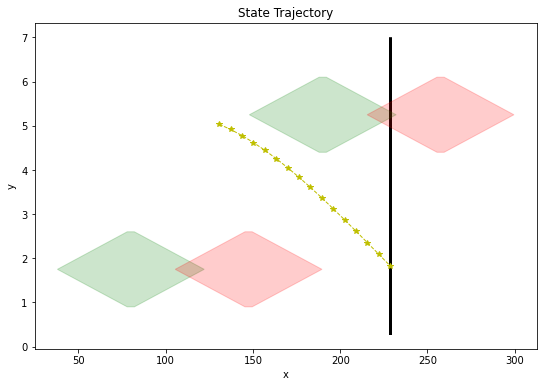

SV Lane Info :  [1, 2]
LV info :  [1, 0]
[[0.58186 0.56127 0.56106 0.57967 0.61555 0.66713 0.73288 0.81124 0.90068
  0.99965 1.10661 1.22003 1.33839 1.46013 1.58374 1.70768]
 [3.46852 3.48911 3.48932 3.47071 3.43483 3.38324 3.3175  3.23913 3.1497
  3.05073 2.94377 2.83034 2.71199 2.59024 2.46663 2.34269]]
[[False False False False False False False False False False False False
  False False False False]
 [False False False False False False False False False False False False
  False False False False]]
20 th step ended
---------------------------------------------------------------------
0th successor calculation
1th successor calculation
2th successor calculation
3th successor calculation
4th successor calculation
5th successor calculation
6th successor calculation
7th successor calculation
8th successor calculation
9th successor calculation
10th successor calculation
11th successor calculation
12th successor calculation
13th successor calculation
14th successor calculation
[[ 235.1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:68: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


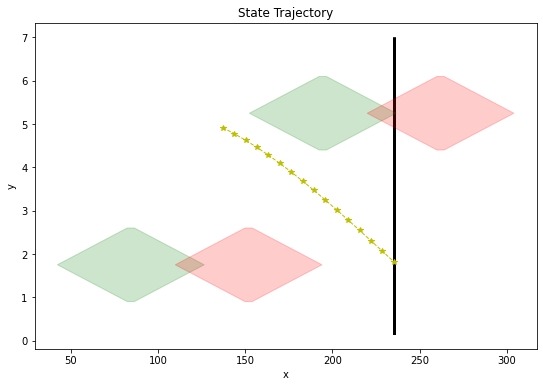

SV Lane Info :  [1, 2]
LV info :  [1, 0]
[[0.65688 0.65569 0.66915 0.69611 0.73547 0.7861  0.8469  0.91676 0.99456
  1.07921 1.1696  1.26463 1.36319 1.4642  1.56654 1.66912]
 [3.3935  3.39468 3.38123 3.35427 3.31491 3.26428 3.20348 3.13362 3.05581
  2.97116 2.88077 2.78575 2.68718 2.58618 2.48384 2.38126]]
[[False False False False False False False False False False False False
  False False False False]
 [False False False False False False False False False False False False
  False False False False]]
21 th step ended
---------------------------------------------------------------------
0th successor calculation
1th successor calculation
2th successor calculation
3th successor calculation
4th successor calculation
5th successor calculation
6th successor calculation
7th successor calculation
8th successor calculation
9th successor calculation
10th successor calculation
11th successor calculation
12th successor calculation
13th successor calculation
14th successor calculation
[[   24

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:68: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


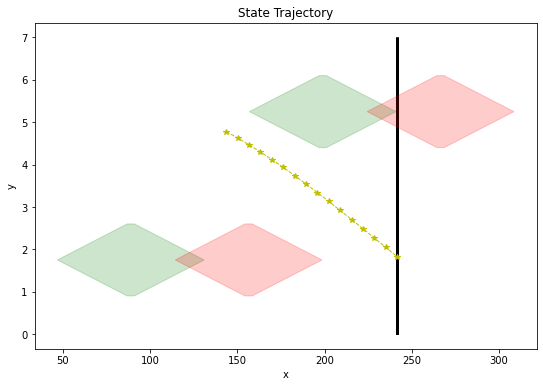

SV Lane Info :  [1, 2]
LV info :  [1, 0]
[[0.7513  0.76388 0.78619 0.8175  0.85705 0.90411 0.95794 1.01779 1.08293
  1.15262 1.22614 1.30274 1.3817  1.46227 1.54374 1.62537]
 [3.29907 3.28649 3.26418 3.23287 3.19332 3.14626 3.09244 3.03259 2.96745
  2.89775 2.82424 2.74764 2.66868 2.5881  2.50663 2.425  ]]
[[False False False False False False False False False False False False
  False False False False]
 [False False False False False False False False False False False False
  False False False False]]
22 th step ended
---------------------------------------------------------------------
0th successor calculation
1th successor calculation
2th successor calculation
3th successor calculation
4th successor calculation
5th successor calculation
6th successor calculation
7th successor calculation
8th successor calculation
9th successor calculation
10th successor calculation
11th successor calculation
12th successor calculation
13th successor calculation
14th successor calculation
[[  248

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:68: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


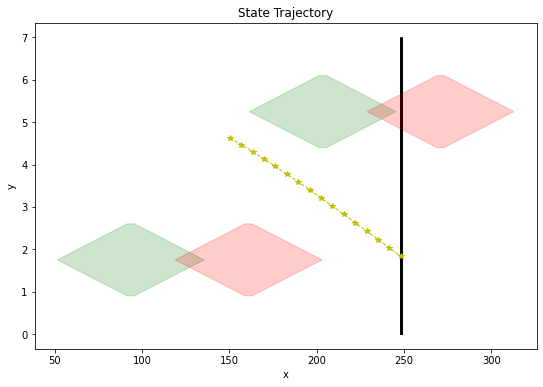

SV Lane Info :  [1, 2]
LV info :  [1, 0]
[[0.85949 0.88101 0.90812 0.94039 0.97738 1.01868 1.06386 1.11249 1.16416
  1.21843 1.2749  1.33314 1.39273 1.45325 1.51428 1.5754 ]
 [3.19089 3.16936 3.14225 3.10999 3.07299 3.0317  2.98652 2.93789 2.88622
  2.83194 2.77547 2.71723 2.65765 2.59713 2.5361  2.47497]]
[[False False False False False False False False False False False False
  False False False False]
 [False False False False False False False False False False False False
  False False False False]]
23 th step ended
---------------------------------------------------------------------
0th successor calculation
1th successor calculation
2th successor calculation
3th successor calculation
4th successor calculation
5th successor calculation
6th successor calculation
7th successor calculation
8th successor calculation
9th successor calculation
10th successor calculation
11th successor calculation
12th successor calculation
13th successor calculation
14th successor calculation
[[  254

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:68: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


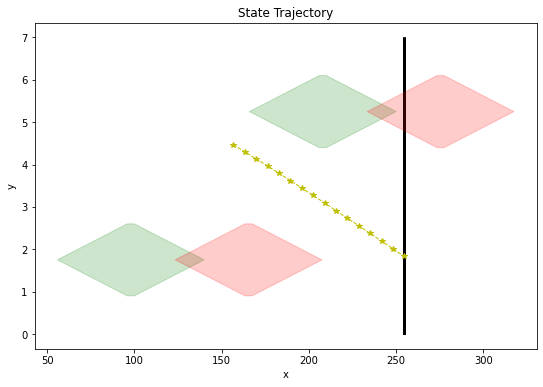

SV Lane Info :  [1, 2]
LV info :  [1, 0]
[[0.97662 1.00306 1.03176 1.06256 1.09527 1.12972 1.16575 1.20317 1.24183
  1.28154 1.32215 1.36347 1.40533 1.44758 1.49003 1.53252]
 [3.07376 3.04732 3.01861 2.98782 2.95511 2.92065 2.88463 2.8472  2.80854
  2.76883 2.72823 2.68691 2.64504 2.6028  2.56034 2.51785]]
[[False False False False False False False False False False False False
  False False False False]
 [False False False False False False False False False False False False
  False False False False]]
24 th step ended
---------------------------------------------------------------------
0th successor calculation
1th successor calculation
2th successor calculation
3th successor calculation
4th successor calculation
5th successor calculation
6th successor calculation
7th successor calculation
8th successor calculation
9th successor calculation
10th successor calculation
11th successor calculation
12th successor calculation
13th successor calculation
14th successor calculation
[[  261

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:68: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


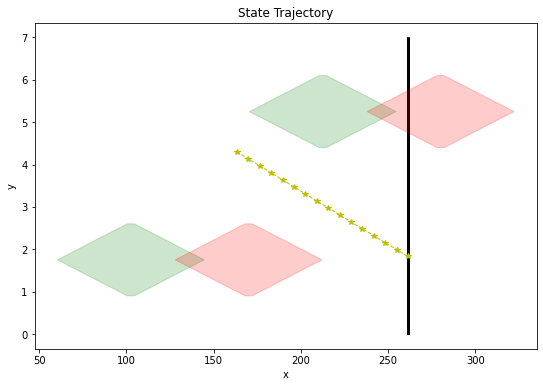

SV Lane Info :  [1, 2]
LV info :  [1, 0]
[[1.09866 1.12678 1.15447 1.18174 1.20865 1.23522 1.26148 1.28747 1.31322
  1.33877 1.36414 1.38938 1.41451 1.43957 1.46459 1.4896 ]
 [2.95171 2.92359 2.89591 2.86863 2.84172 2.81516 2.78889 2.7629  2.73715
  2.71161 2.68623 2.66099 2.63586 2.6108  2.58579 2.56077]]
[[False False False False False False False False False False False False
  False False False False]
 [False False False False False False False False False False False False
  False False False False]]
25 th step ended
---------------------------------------------------------------------
0th successor calculation
1th successor calculation
2th successor calculation
3th successor calculation
4th successor calculation
5th successor calculation
6th successor calculation
7th successor calculation
8th successor calculation
9th successor calculation
10th successor calculation
11th successor calculation
12th successor calculation
13th successor calculation
14th successor calculation
[[  267

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:68: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


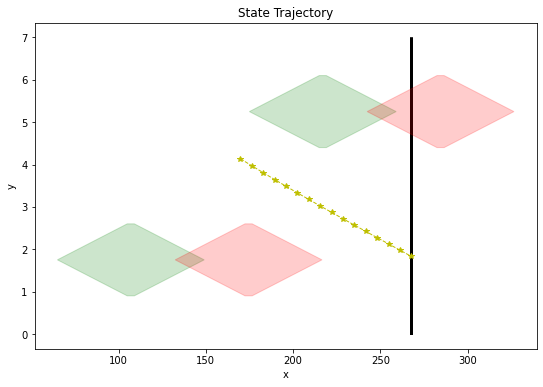

SV Lane Info :  [1, 2]
LV info :  [1, 0]
[[1.22238 1.24956 1.27413 1.2963  1.31626 1.33421 1.35035 1.36488 1.37799
  1.38988 1.40075 1.4108  1.42021 1.4292  1.43794 1.44665]
 [2.82799 2.80081 2.77624 2.75408 2.73412 2.71617 2.70003 2.6855  2.67239
  2.66049 2.64962 2.63958 2.63016 2.62118 2.61243 2.60373]]
[[False False False False False False False False False False False False
  False False False False]
 [False False False False False False False False False False False False
  False False False False]]
26 th step ended
---------------------------------------------------------------------
0th successor calculation
1th successor calculation
2th successor calculation
3th successor calculation
4th successor calculation
5th successor calculation
6th successor calculation
7th successor calculation
8th successor calculation
9th successor calculation
10th successor calculation
11th successor calculation
12th successor calculation
13th successor calculation
14th successor calculation
[[  274

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:68: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


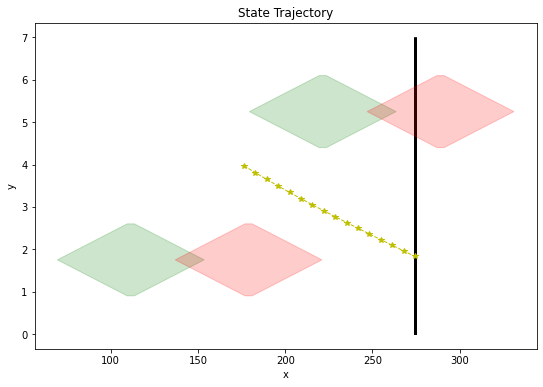

SV Lane Info :  [1, 2]
LV info :  [1, 0]
[[1.34516 1.3693  1.38912 1.40496 1.41715 1.42602 1.43189 1.43509 1.43594
  1.43478 1.43193 1.42771 1.42245 1.41647 1.4101  1.40366]
 [2.70522 2.68108 2.66126 2.64541 2.63322 2.62436 2.61849 2.61529 2.61443
  2.61559 2.61844 2.62266 2.62792 2.6339  2.64027 2.64671]]
[[False False False False False False False False False False False False
  False False False False]
 [False False False False False False False False False False False False
  False False False False]]
27 th step ended
---------------------------------------------------------------------
0th successor calculation
1th successor calculation
2th successor calculation
3th successor calculation
4th successor calculation
5th successor calculation
6th successor calculation
7th successor calculation
8th successor calculation
9th successor calculation
10th successor calculation
11th successor calculation
12th successor calculation
13th successor calculation
14th successor calculation
[[  280

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:68: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


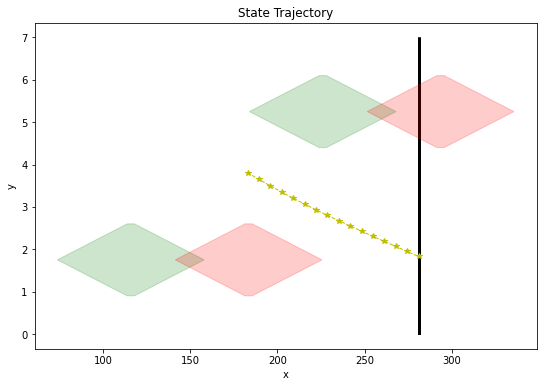

SV Lane Info :  [1, 2]
LV info :  [1, 0]
[[1.46489 1.48434 1.49816 1.50679 1.51066 1.51018 1.5058  1.49794 1.48702
  1.47347 1.45771 1.44017 1.42127 1.40144 1.38109 1.36065]
 [2.58548 2.56603 2.55221 2.54358 2.53972 2.54019 2.54457 2.55244 2.56336
  2.57691 2.59266 2.6102  2.6291  2.64894 2.66929 2.68973]]
[[False False False False False False False False False False False False
  False False False False]
 [False False False False False False False False False False False False
  False False False False]]
28 th step ended
---------------------------------------------------------------------
0th successor calculation
1th successor calculation
2th successor calculation
3th successor calculation
4th successor calculation
5th successor calculation
6th successor calculation
7th successor calculation
8th successor calculation
9th successor calculation
10th successor calculation
11th successor calculation
12th successor calculation
13th successor calculation
14th successor calculation
[[  287

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:68: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


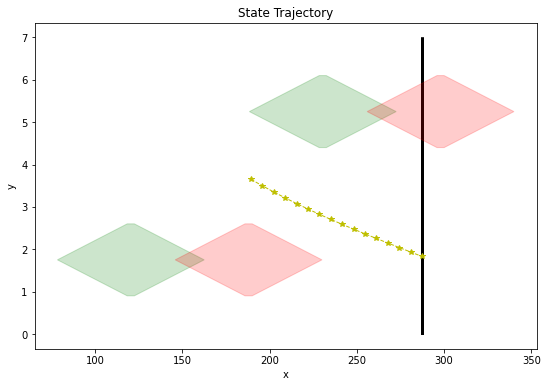

SV Lane Info :  [1, 2]
LV info :  [1, 0]
[[1.57994 1.59344 1.60034 1.60114 1.59635 1.58646 1.57199 1.55343 1.53128
  1.50604 1.47821 1.44829 1.41677 1.38416 1.35094 1.31761]
 [2.47044 2.45694 2.45004 2.44924 2.45403 2.46391 2.47839 2.49695 2.5191
  2.54433 2.57216 2.60208 2.6336  2.66622 2.69944 2.73277]]
[[False False False False False False False False False False False False
  False False False False]
 [False False False False False False False False False False False False
  False False False False]]
29 th step ended
---------------------------------------------------------------------
0th successor calculation
1th successor calculation
2th successor calculation
3th successor calculation
4th successor calculation
5th successor calculation
6th successor calculation
7th successor calculation
8th successor calculation
9th successor calculation
10th successor calculation
11th successor calculation
12th successor calculation
13th successor calculation
14th successor calculation
[[  293.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:68: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


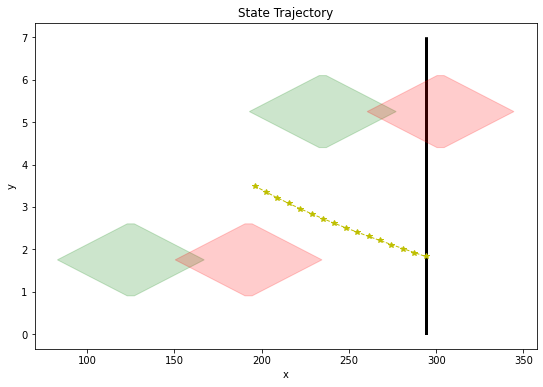

SV Lane Info :  [1, 2]
LV info :  [1, 0]
[[1.68903 1.69566 1.69499 1.68757 1.67397 1.65475 1.63045 1.60163 1.56885
  1.53265 1.49358 1.45221 1.40907 1.36471 1.31969 1.27455]
 [2.36134 2.35472 2.35539 2.3628  2.3764  2.39563 2.41993 2.44875 2.48153
  2.51773 2.55679 2.59817 2.64131 2.68566 2.73069 2.77583]]
[[False False False False False False False False False False False False
  False False False False]
 [False False False False False False False False False False False False
  False False False False]]
30 th step ended
---------------------------------------------------------------------
0th successor calculation
1th successor calculation
2th successor calculation
3th successor calculation
4th successor calculation
5th successor calculation
6th successor calculation
7th successor calculation
8th successor calculation
9th successor calculation
10th successor calculation
11th successor calculation
12th successor calculation
13th successor calculation
14th successor calculation
[[  300

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:68: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


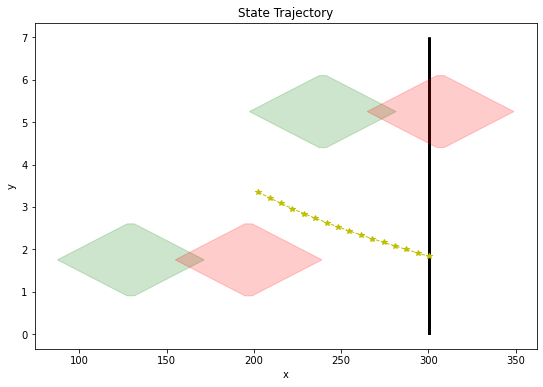

SV Lane Info :  [1, 2]
LV info :  [1, 0]
[[1.79125 1.79035 1.78169 1.76586 1.74346 1.71507 1.6813  1.64272 1.59992
  1.5535  1.50403 1.4521  1.3983  1.3432  1.2874  1.23147]
 [2.25912 2.26002 2.26869 2.28452 2.30692 2.3353  2.36908 2.40766 2.45045
  2.49688 2.54634 2.59827 2.65208 2.70717 2.76297 2.8189 ]]
[[False False False False False False False False False False False False
  False False False False]
 [False False False False False False False False False False False False
  False False False False]]
31 th step ended
---------------------------------------------------------------------
0th successor calculation
1th successor calculation
2th successor calculation
3th successor calculation
4th successor calculation
5th successor calculation
6th successor calculation
7th successor calculation
8th successor calculation
9th successor calculation
10th successor calculation
11th successor calculation
12th successor calculation
13th successor calculation
14th successor calculation
[[  306

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:68: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


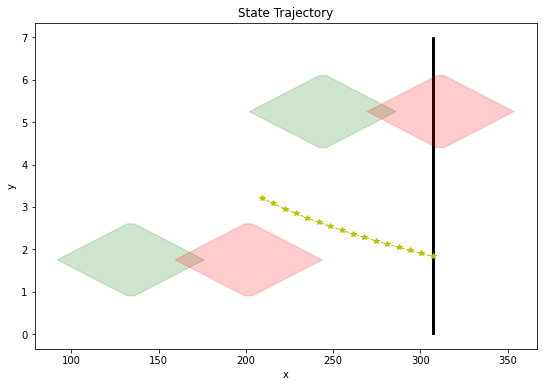

SV Lane Info :  [1, 2]
LV info :  [1, 0]
[[1.88594 1.87709 1.86021 1.83592 1.80484 1.76758 1.72473 1.67693 1.62476
  1.56884 1.50978 1.44817 1.38462 1.31974 1.25412 1.18838]
 [2.16443 2.17329 2.19017 2.21445 2.24553 2.2828  2.32564 2.37345 2.42561
  2.48153 2.5406  2.60221 2.66575 2.73064 2.79625 2.862  ]]
[[False False False False False False False False False False False False
  False False False False]
 [False False False False False False False False False False False False
  False False False False]]
32 th step ended
---------------------------------------------------------------------
0th successor calculation
1th successor calculation
2th successor calculation
3th successor calculation
4th successor calculation
5th successor calculation
6th successor calculation
7th successor calculation
8th successor calculation
9th successor calculation
10th successor calculation
11th successor calculation
12th successor calculation
13th successor calculation
14th successor calculation
[[  313

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:68: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


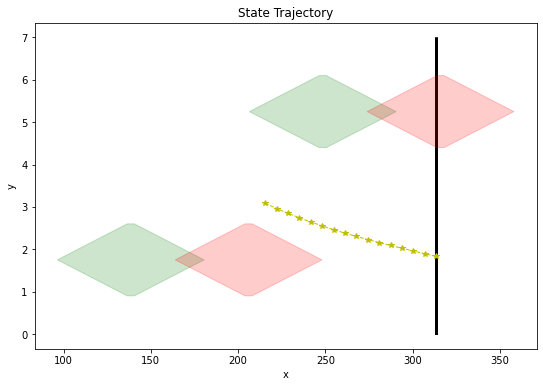

SV Lane Info :  [1, 2]
LV info :  [1, 0]
[[1.97268 1.95564 1.93048 1.89782 1.85828 1.81247 1.76102 1.70454 1.64365
  1.57895 1.51107 1.44062 1.3682  1.29443 1.21991 1.14527]
 [2.07769 2.09473 2.11989 2.15256 2.1921  2.23791 2.28936 2.34584 2.40673
  2.47142 2.5393  2.60976 2.68218 2.75595 2.83046 2.90511]]
[[False False False False False False False False False False False False
  False False False False]
 [False False False False False False False False False False False False
  False False False False]]
33 th step ended
---------------------------------------------------------------------
0th successor calculation
1th successor calculation
2th successor calculation
3th successor calculation
4th successor calculation
5th successor calculation
6th successor calculation
7th successor calculation
8th successor calculation
9th successor calculation
10th successor calculation
11th successor calculation
12th successor calculation
13th successor calculation
14th successor calculation
[[  320

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:68: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


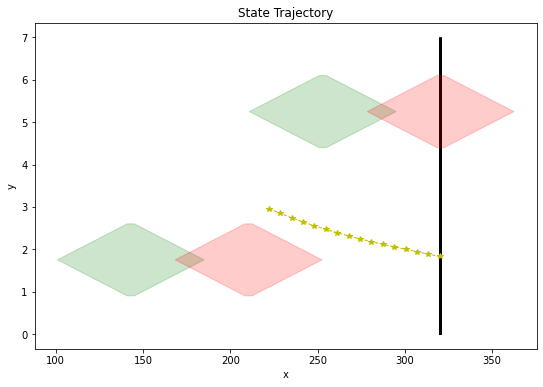

SV Lane Info :  [1, 2]
LV info :  [1, 0]
[[2.05124 2.02594 1.99256 1.9517  1.90399 1.85003 1.79046 1.72587 1.65689
  1.58412 1.50817 1.42967 1.3492  1.26739 1.18483 1.10215]
 [1.99914 2.02443 2.05782 2.09867 2.14639 2.20034 2.25992 2.3245  2.39349
  2.46626 2.5422  2.62071 2.70118 2.78299 2.86554 2.94822]]
[[False False False False False False False False False False False False
  False False False False]
 [False False False False False False False False False False False False
  False False False False]]
34 th step ended
---------------------------------------------------------------------
0th successor calculation
1th successor calculation
2th successor calculation
3th successor calculation
4th successor calculation
5th successor calculation
6th successor calculation
7th successor calculation
8th successor calculation
9th successor calculation
10th successor calculation
11th successor calculation
12th successor calculation
13th successor calculation
14th successor calculation
[[  326

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:68: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


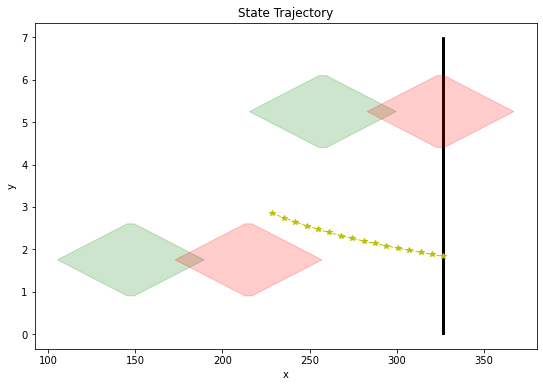

SV Lane Info :  [1, 2]
LV info :  [1, 0]
[[2.12154 2.08805 2.0466  1.9978  1.94227 1.88059 1.81339 1.74127 1.66482
  1.58465 1.50135 1.41554 1.3278  1.23873 1.14894 1.05902]
 [1.92884 1.96233 2.00378 2.05257 2.10811 2.16978 2.23698 2.30911 2.38556
  2.46573 2.54902 2.63484 2.72258 2.81164 2.90143 2.99135]]
[[False False False False False False False False False False False False
  False False False False]
 [False False False False False False False False False False False False
  False False False False]]
35 th step ended
---------------------------------------------------------------------
0th successor calculation
1th successor calculation
2th successor calculation
3th successor calculation
4th successor calculation
5th successor calculation
6th successor calculation
7th successor calculation
8th successor calculation
9th successor calculation
10th successor calculation
11th successor calculation
12th successor calculation
13th successor calculation
14th successor calculation
[[  333

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:68: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


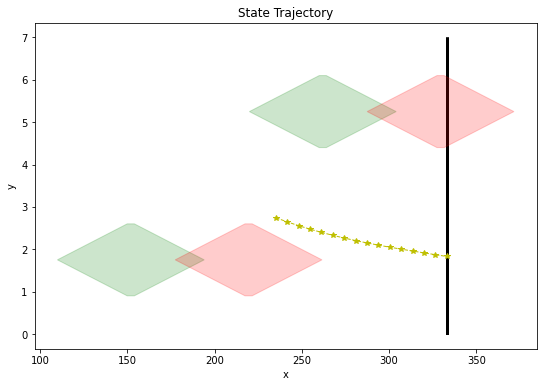

SV Lane Info :  [1, 2]
LV info :  [1, 0]
[[2.18364 2.14211 2.09284 2.03642 1.97345 1.90451 1.83019 1.75108 1.66777
  1.58084 1.49088 1.39846 1.30417 1.20859 1.1123  1.01589]
 [1.86674 1.90827 1.95754 2.01396 2.07693 2.14587 2.22018 2.29929 2.3826
  2.46953 2.5595  2.65192 2.74621 2.84179 2.93807 3.03448]]
[[False False False False False False False False False False False False
  False False False False]
 [False False False False False False False False False False False False
  False False False False]]
36 th step ended
---------------------------------------------------------------------
0th successor calculation
1th successor calculation
2th successor calculation
3th successor calculation
4th successor calculation
5th successor calculation
6th successor calculation
7th successor calculation
8th successor calculation
9th successor calculation
10th successor calculation
11th successor calculation
12th successor calculation
13th successor calculation
14th successor calculation
[[  339.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:68: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


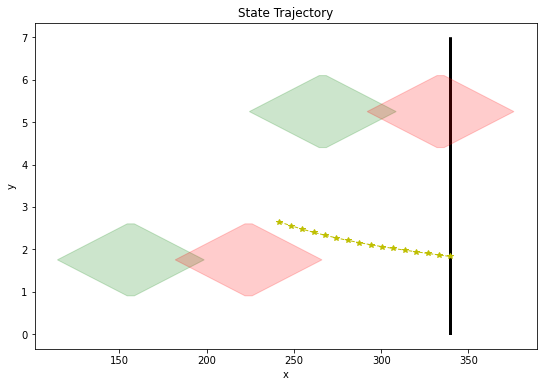

SV Lane Info :  [1, 2]
LV info :  [1, 0]
[[2.2377  2.18836 2.13157 2.06789 1.99789 1.92215 1.84123 1.75569 1.66609
  1.57301 1.47701 1.37864 1.27847 1.17706 1.07496 0.97275]
 [1.81267 1.86201 1.91881 1.98248 2.05248 2.12822 2.20915 2.29469 2.38428
  2.47736 2.57337 2.67173 2.7719  2.87332 2.97541 3.07762]]
[[False False False False False False False False False False False False
  False False False False]
 [False False False False False False False False False False False False
  False False False False]]
37 th step ended
---------------------------------------------------------------------
0th successor calculation
1th successor calculation
2th successor calculation
3th successor calculation
4th successor calculation
5th successor calculation
6th successor calculation
7th successor calculation
8th successor calculation
9th successor calculation
10th successor calculation
11th successor calculation
12th successor calculation
13th successor calculation
14th successor calculation
[[  346

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:68: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


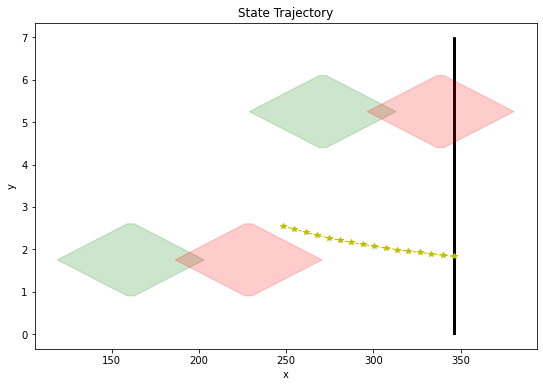

SV Lane Info :  [1, 2]
LV info :  [1, 0]
[[2.28396 2.22711 2.16314 2.09259 2.016   1.93392 1.84688 1.75544 1.66012
  1.56146 1.46002 1.35631 1.25088 1.14426 1.03699 0.92961]
 [1.76642 1.82326 1.88723 1.95778 2.03437 2.11646 2.20349 2.29494 2.39026
  2.48891 2.59036 2.69407 2.7995  2.90612 3.01338 3.12077]]
[[False False False False False False False False False False False False
  False False False False]
 [False False False False False False False False False False False False
  False False False False]]
38 th step ended
---------------------------------------------------------------------
0th successor calculation
1th successor calculation
2th successor calculation
3th successor calculation
4th successor calculation
5th successor calculation
6th successor calculation
7th successor calculation
8th successor calculation
9th successor calculation
10th successor calculation
11th successor calculation
12th successor calculation
13th successor calculation
14th successor calculation
[[  352

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:68: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


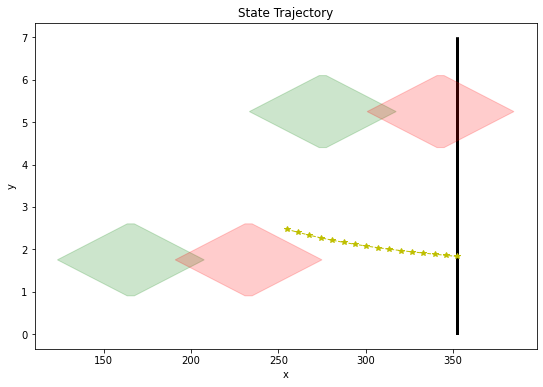

SV Lane Info :  [1, 2]
LV info :  [1, 0]
[[2.32271 2.2587  2.18793 2.11091 2.02817 1.94021 1.84754 1.7507  1.65017
  1.54649 1.44015 1.33166 1.22154 1.1103  0.99843 0.88646]
 [1.72767 1.79167 1.86244 1.93946 2.02221 2.11017 2.20283 2.29968 2.4002
  2.50389 2.61023 2.71871 2.82883 2.94008 3.05194 3.16391]]
[[False False False False False False False False False False False False
  False False False False]
 [False False False False False False False False False False False False
  False False False False]]
39 th step ended
---------------------------------------------------------------------
0th successor calculation
1th successor calculation
2th successor calculation
3th successor calculation
4th successor calculation
5th successor calculation
6th successor calculation
7th successor calculation
8th successor calculation
9th successor calculation
10th successor calculation
11th successor calculation
12th successor calculation
13th successor calculation
14th successor calculation
[[  359.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:68: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


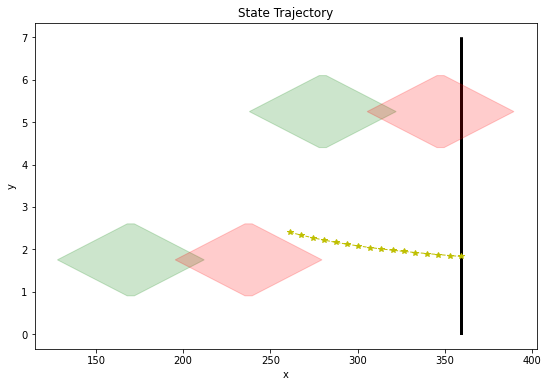

SV Lane Info :  [1, 2]
LV info :  [1, 0]
[[2.3543  2.2835  2.20633 2.12326 2.03479 1.9414  1.84358 1.74182 1.63658
  1.52837 1.41765 1.3049  1.19062 1.07527 0.95934 0.84331]
 [1.69608 1.76687 1.84405 1.92712 2.01558 2.10897 2.20679 2.30856 2.41379
  2.52201 2.63273 2.74547 2.85976 2.9751  3.09103 3.20706]]
[[False False False False False False False False False False False False
  False False False False]
 [False False False False False False False False False False False False
  False False False False]]
40 th step ended
---------------------------------------------------------------------
0th successor calculation
1th successor calculation
2th successor calculation
3th successor calculation
4th successor calculation
5th successor calculation
6th successor calculation
7th successor calculation
8th successor calculation
9th successor calculation
10th successor calculation
11th successor calculation
12th successor calculation
13th successor calculation
14th successor calculation
[[  365

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:68: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


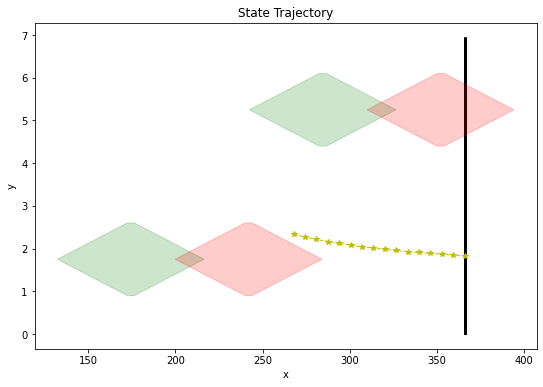

SV Lane Info :  [1, 2]
LV info :  [1, 0]
[[2.3791  2.30191 2.21873 2.13004 2.03627 1.9379  1.83537 1.72914 1.61965
  1.50737 1.39274 1.27622 1.15825 1.03928 0.91977 0.80016]
 [1.67128 1.74847 1.83164 1.92034 2.0141  2.11247 2.215   2.32124 2.43072
  2.543   2.65763 2.77415 2.89212 3.01109 3.1306  3.25021]]
[[False False False False False False False False False False False False
  False False False False]
 [False False False False False False False False False False False False
  False False False False]]
41 th step ended
---------------------------------------------------------------------
0th successor calculation
1th successor calculation
2th successor calculation
3th successor calculation
4th successor calculation
5th successor calculation
6th successor calculation
7th successor calculation
8th successor calculation
9th successor calculation
10th successor calculation
11th successor calculation
12th successor calculation
13th successor calculation
14th successor calculation
[[  372

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:68: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


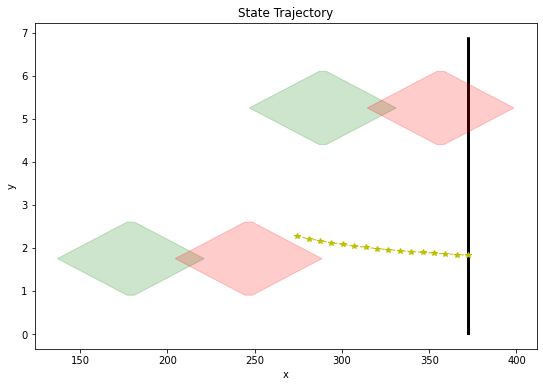

SV Lane Info :  [1, 2]
LV info :  [1, 0]
[[2.39751 2.31433 2.22556 2.13165 2.03301 1.93007 1.82325 1.71298 1.59968
  1.48377 1.36566 1.24579 1.12457 1.00242 0.87976 0.75701]
 [1.65287 1.73605 1.82481 1.91872 2.01736 2.1203  2.22712 2.33739 2.4507
  2.56661 2.68471 2.80458 2.9258  3.04795 3.17061 3.29336]]
[[False False False False False False False False False False False False
  False False False False]
 [False False False False False False False False False False False False
  False False False False]]
42 th step ended
---------------------------------------------------------------------
0th successor calculation
1th successor calculation
2th successor calculation
3th successor calculation
4th successor calculation
5th successor calculation
6th successor calculation
7th successor calculation
8th successor calculation
9th successor calculation
10th successor calculation
11th successor calculation
12th successor calculation
13th successor calculation
14th successor calculation
[[  378.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:68: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


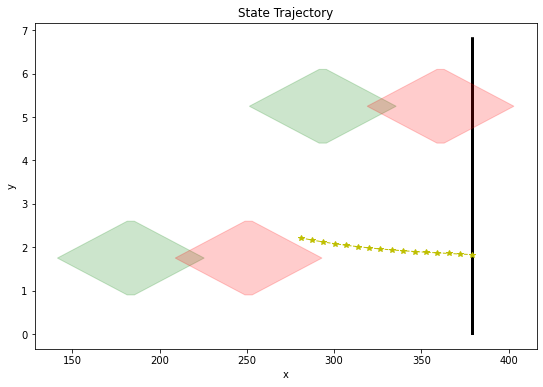

SV Lane Info :  [1, 2]
LV info :  [1, 0]
[[2.40993 2.32116 2.22722 2.1285  2.02538 1.91828 1.80757 1.69366 1.57694
  1.45779 1.33661 1.21378 1.08971 0.96477 0.83936 0.71387]
 [1.64045 1.72921 1.82315 1.92188 2.02499 2.1321  2.2428  2.35671 2.47344
  2.59259 2.71377 2.83659 2.96067 3.0856  3.21101 3.33651]]
[[False False False False False False False False False False False False
  False False False False]
 [False False False False False False False False False False False False
  False False False False]]
43 th step ended
---------------------------------------------------------------------
0th successor calculation
1th successor calculation
2th successor calculation
3th successor calculation
4th successor calculation
5th successor calculation
6th successor calculation
7th successor calculation
8th successor calculation
9th successor calculation
10th successor calculation
11th successor calculation
12th successor calculation
13th successor calculation
14th successor calculation
[[  385

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:68: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


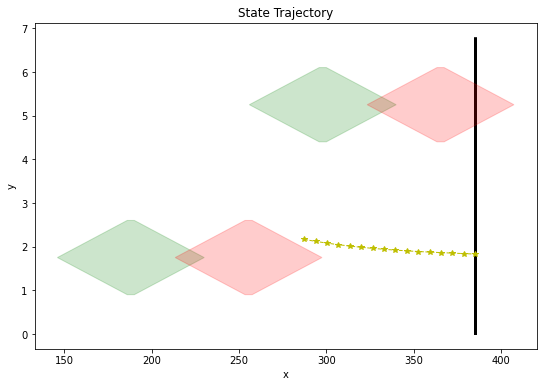

SV Lane Info :  [1, 2]
LV info :  [1, 0]
[[2.41677 2.32283 2.2241  2.12096 2.01376 1.90287 1.78865 1.67147 1.55169
  1.42967 1.30577 1.18035 1.05378 0.92641 0.7986  0.67072]
 [1.63361 1.72755 1.82627 1.92942 2.03662 2.14751 2.26173 2.37891 2.49869
  2.62071 2.7446  2.87002 2.99659 3.12396 3.25177 3.37965]]
[[False False False False False False False False False False False False
  False False False False]
 [False False False False False False False False False False False False
  False False False False]]
44 th step ended
---------------------------------------------------------------------
0th successor calculation
1th successor calculation
2th successor calculation
3th successor calculation
4th successor calculation
5th successor calculation
6th successor calculation
7th successor calculation
8th successor calculation
9th successor calculation
10th successor calculation
11th successor calculation
12th successor calculation
13th successor calculation
14th successor calculation
[[  391

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:68: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


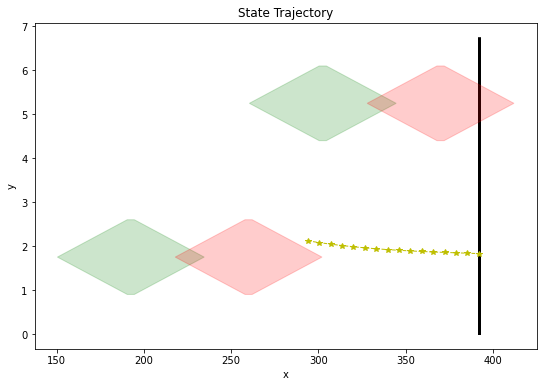

SV Lane Info :  [1, 2]
LV info :  [1, 0]
[[2.41843 2.31971 2.21659 2.1094  1.99848 1.88416 1.76678 1.64668 1.52418
  1.39962 1.27333 1.14565 1.0169  0.88742 0.75753 0.62758]
 [1.63194 1.73066 1.83379 1.94098 2.0519  2.16621 2.28359 2.4037  2.5262
  2.65075 2.77704 2.90473 3.03348 3.16296 3.29284 3.4228 ]]
[[False False False False False False False False False False False False
  False False False False]
 [False False False False False False False False False False False False
  False False False False]]
45 th step ended
---------------------------------------------------------------------
0th successor calculation
1th successor calculation
2th successor calculation
3th successor calculation
4th successor calculation
5th successor calculation
6th successor calculation
7th successor calculation
8th successor calculation
9th successor calculation
10th successor calculation
11th successor calculation
12th successor calculation
13th successor calculation
14th successor calculation
[[  398.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:68: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


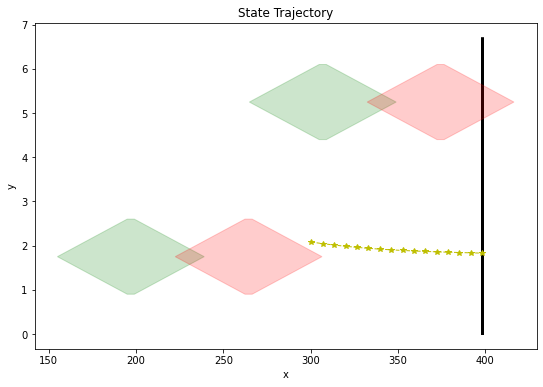

SV Lane Info :  [1, 2]
LV info :  [1, 0]
[[2.41532 2.31221 2.20506 2.09418 1.97988 1.86247 1.74226 1.61955 1.49464
  1.36784 1.23946 1.1098  0.97916 0.84785 0.71618 0.58443]
 [1.63506 1.73817 1.84532 1.95619 2.07049 2.1879  2.30811 2.43083 2.55574
  2.68253 2.81091 2.94057 3.07121 3.20252 3.3342  3.46594]]
[[False False False False False False False False False False False False
  False False False False]
 [False False False False False False False False False False False False
  False False False False]]
46 th step ended
---------------------------------------------------------------------
0th successor calculation
1th successor calculation
2th successor calculation
3th successor calculation
4th successor calculation
5th successor calculation
6th successor calculation
7th successor calculation
8th successor calculation
9th successor calculation
10th successor calculation
11th successor calculation
12th successor calculation
13th successor calculation
14th successor calculation
[[  404

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:68: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


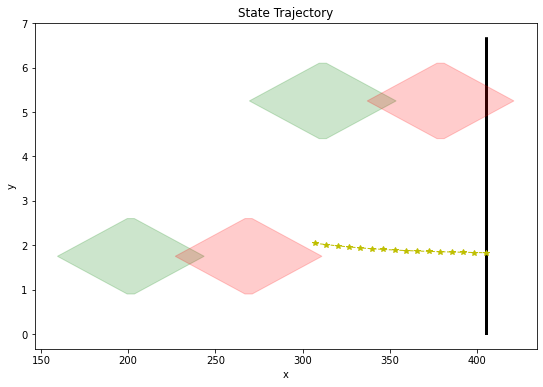

SV Lane Info :  [1, 2]
LV info :  [1, 0]
[[2.40781 2.30068 2.18986 2.07563 1.95829 1.8381  1.71535 1.59032 1.46328
  1.33452 1.20431 1.07294 0.94067 0.80779 0.67457 0.54129]
 [1.64256 1.7497  1.86052 1.97474 2.09209 2.21228 2.33503 2.46006 2.58709
  2.71585 2.84606 2.97744 3.1097  3.24259 3.3758  3.50908]]
[[False False False False False False False False False False False False
  False False False False]
 [False False False False False False False False False False False False
  False False False False]]
47 th step ended
---------------------------------------------------------------------
0th successor calculation
1th successor calculation
2th successor calculation
3th successor calculation
4th successor calculation
5th successor calculation
6th successor calculation
7th successor calculation
8th successor calculation
9th successor calculation
10th successor calculation
11th successor calculation
12th successor calculation
13th successor calculation
14th successor calculation
[[  411

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:68: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


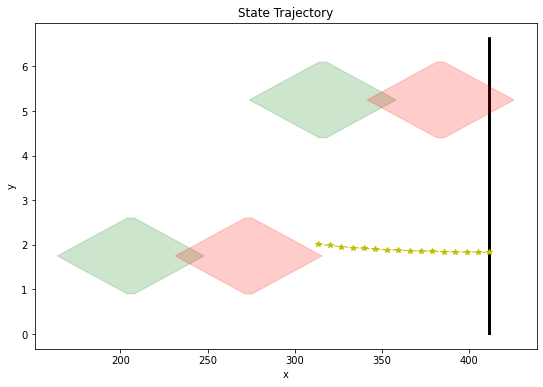

SV Lane Info :  [1, 2]
LV info :  [1, 0]
[[2.39628 2.28548 2.17132 2.05407 1.93397 1.81129 1.68629 1.5592  1.43029
  1.29982 1.16802 1.03517 0.9015  0.76727 0.63274 0.49815]
 [1.65409 1.7649  1.87905 1.99631 2.1164  2.23908 2.36409 2.49117 2.62008
  2.75056 2.88235 3.01521 3.14887 3.2831  3.41763 3.55222]]
[[False False False False False False False False False False False False
  False False False False]
 [False False False False False False False False False False False False
  False False False False]]
48 th step ended
---------------------------------------------------------------------
0th successor calculation
1th successor calculation
2th successor calculation
3th successor calculation
4th successor calculation
5th successor calculation
6th successor calculation
7th successor calculation
8th successor calculation
9th successor calculation
10th successor calculation
11th successor calculation
12th successor calculation
13th successor calculation
14th successor calculation
[[  417

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:68: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


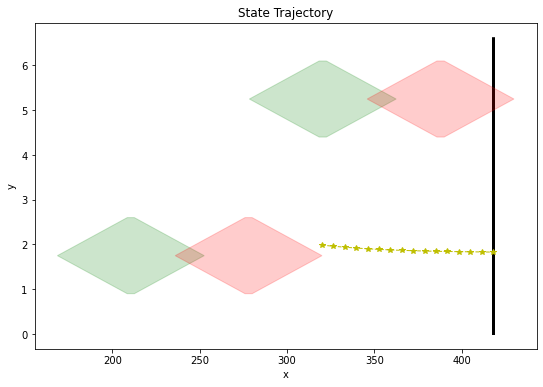

SV Lane Info :  [1, 2]
LV info :  [1, 0]
[[2.38109 2.26695 2.14977 2.02978 1.90722 1.78232 1.6553  1.5264  1.39585
  1.26388 1.13072 0.99659 0.86173 0.72636 0.59071 0.45502]
 [1.66929 1.78343 1.90061 2.0206  2.14316 2.26806 2.39507 2.52397 2.65452
  2.78649 2.91966 3.05378 3.18865 3.32401 3.45966 3.59536]]
[[False False False False False False False False False False False False
  False False False False]
 [False False False False False False False False False False False False
  False False False False]]
49 th step ended
---------------------------------------------------------------------
0th successor calculation
1th successor calculation
2th successor calculation
3th successor calculation
4th successor calculation
5th successor calculation
6th successor calculation
7th successor calculation
8th successor calculation
9th successor calculation
10th successor calculation
11th successor calculation
12th successor calculation
13th successor calculation
14th successor calculation
[[  424

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:68: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


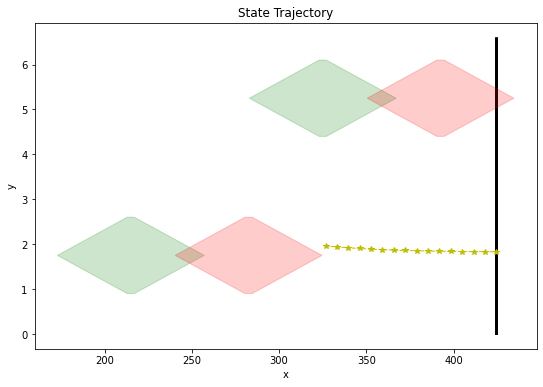

SV Lane Info :  [1, 2]
LV info :  [-1, 0]
[[-1.9605  -1.93891 -1.92005 -1.90374 -1.88975 -1.87787 -1.8679  -1.85964
  -1.85286 -1.84737 -1.84296 -1.83941 -1.83653 -1.83411 -1.83193 -1.82981]
 [ 1.68782  1.80498  1.92489  2.04733  2.1721   2.29898  2.42777  2.55826
   2.69024  2.82351  2.95785  3.09307  3.22894  3.36528  3.50186  3.63849]]
[[ True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True]
 [False False False False False False False False False False False False
  False False False False]]
50 th step ended
---------------------------------------------------------------------
0th successor calculation
1th successor calculation
2th successor calculation
3th successor calculation
4th successor calculation
5th successor calculation
6th successor calculation
7th successor calculation
8th successor calculation
9th successor calculation
10th successor calculation
11th successor calculation
12th successor calculation
13th successor calculation
1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:68: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


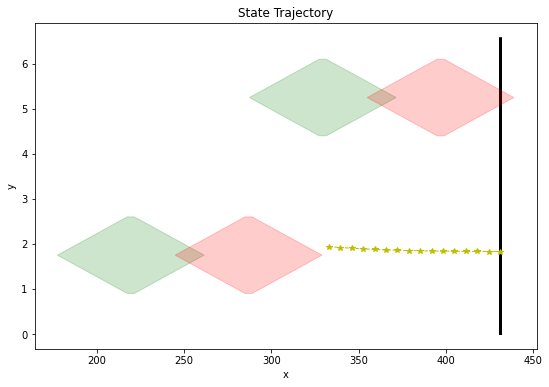

SV Lane Info :  [1, 2]
LV info :  [-1, 0]
[[-1.93892 -1.92005 -1.90365 -1.88954 -1.87751 -1.8674  -1.85899 -1.85212
  -1.84659 -1.84222 -1.83881 -1.83619 -1.83417 -1.83256 -1.83117 -1.82982]
 [ 1.70937  1.82926  1.95162  2.07626  2.20299  2.33163  2.46199  2.59387
   2.7271   2.86148  2.99683  3.13297  3.2697   3.40684  3.54421  3.68162]]
[[ True  True  True  True  True  True  True  True  True  True  True  True
   True  True  True  True]
 [False False False False False False False False False False False False
  False False False False]]
51 th step ended
---------------------------------------------------------------------
0th successor calculation
1th successor calculation
2th successor calculation
3th successor calculation
4th successor calculation
5th successor calculation
6th successor calculation
7th successor calculation
8th successor calculation
9th successor calculation
10th successor calculation
11th successor calculation
12th successor calculation
13th successor calculation
1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:68: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


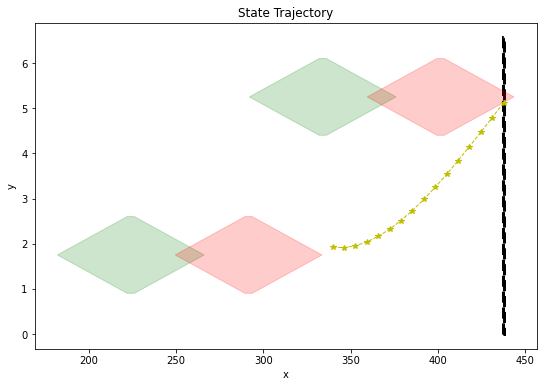

SV Lane Info :  [1, 1]
LV info :  [-1, 0]
52 th step ended
---------------------------------------------------------------------
0th successor calculation
1th successor calculation
2th successor calculation
3th successor calculation
4th successor calculation
5th successor calculation
6th successor calculation
7th successor calculation
8th successor calculation
9th successor calculation
10th successor calculation
11th successor calculation
12th successor calculation
13th successor calculation
14th successor calculation
[[  444.08298   444.09298   444.10298 ...   444.08298   444.09298
    444.10298]
 [    0.01        0.01        0.01    ...     6.59        6.59
      6.59   ]
 [15036.0232  15036.0232  15036.0232  ...    34.32499    34.32499
     34.32499]]
risk value :  0.6465161299173016


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:68: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


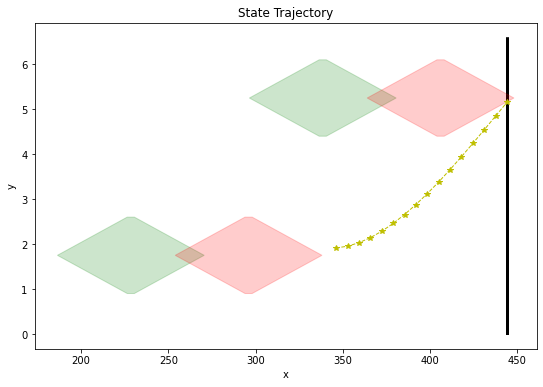

SV Lane Info :  [1, 1]
LV info :  [-1, 0]
53 th step ended
---------------------------------------------------------------------
0th successor calculation
1th successor calculation
2th successor calculation
3th successor calculation
4th successor calculation
5th successor calculation
6th successor calculation
7th successor calculation
8th successor calculation
9th successor calculation
10th successor calculation
11th successor calculation
12th successor calculation
13th successor calculation
14th successor calculation
[[  450.61137   450.62137   450.63137 ...   450.61137   450.62137
    450.63137]
 [    0.01        0.01        0.01    ...     6.66        6.66
      6.66   ]
 [15036.0232  15036.0232  15036.0232  ...    41.30745    41.30745
     41.30745]]
risk value :  0.6458671964406718


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:68: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


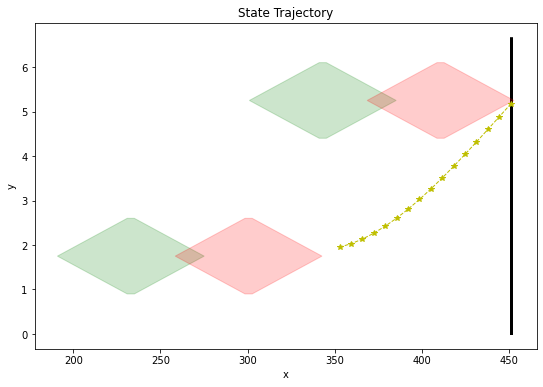

SV Lane Info :  [1, 1]
LV info :  [-1, 0]
54 th step ended
---------------------------------------------------------------------
0th successor calculation
1th successor calculation
2th successor calculation
3th successor calculation
4th successor calculation
5th successor calculation
6th successor calculation
7th successor calculation
8th successor calculation
9th successor calculation
10th successor calculation
11th successor calculation
12th successor calculation
13th successor calculation
14th successor calculation
[[  457.13936   457.14936   457.15936 ...   457.13936   457.14936
    457.15936]
 [    0.01        0.01        0.01    ...     6.76        6.76
      6.76   ]
 [15036.0232  15036.0232  15036.0232  ...    58.00522    58.00522
     58.00522]]
risk value :  0.6458671964406718


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:68: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


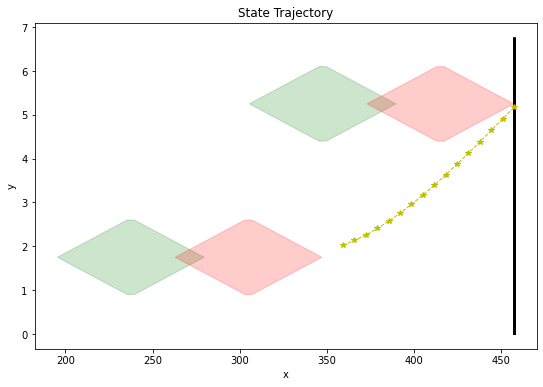

SV Lane Info :  [1, 1]
LV info :  [-1, 0]
55 th step ended
---------------------------------------------------------------------
0th successor calculation
1th successor calculation
2th successor calculation
3th successor calculation
4th successor calculation
5th successor calculation
6th successor calculation
7th successor calculation
8th successor calculation
9th successor calculation
10th successor calculation
11th successor calculation
12th successor calculation
13th successor calculation
14th successor calculation
[[  463.66688   463.67688   463.68688 ...   463.66688   463.67688
    463.68688]
 [    0.01        0.01        0.01    ...     6.88        6.88
      6.88   ]
 [15036.0232  15036.0232  15036.0232  ...   139.13483   139.13483
    139.13483]]
risk value :  0.6458671964406718


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:68: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


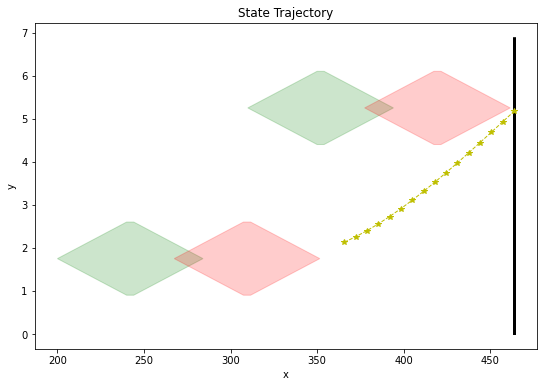

SV Lane Info :  [1, 1]
LV info :  [-1, 0]
56 th step ended
---------------------------------------------------------------------
0th successor calculation
1th successor calculation
2th successor calculation
3th successor calculation
4th successor calculation
5th successor calculation
6th successor calculation
7th successor calculation
8th successor calculation
9th successor calculation
10th successor calculation
11th successor calculation
12th successor calculation
13th successor calculation
14th successor calculation
[[  470.19394   470.20394   470.21394 ...   470.19394   470.20394
    470.21394]
 [    0.01        0.01        0.01    ...     6.98        6.98
      6.98   ]
 [15036.0232  15036.0232  15036.0232  ...  3786.00081  3786.00081
   3786.00081]]
risk value :  0.6458671964406718


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:68: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


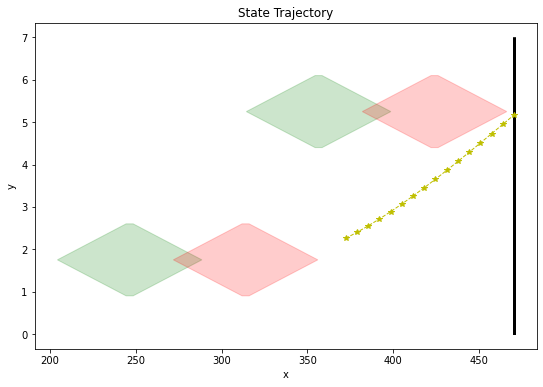

SV Lane Info :  [1, 1]
LV info :  [-1, 0]
57 th step ended
---------------------------------------------------------------------
0th successor calculation
1th successor calculation
2th successor calculation
3th successor calculation
4th successor calculation
5th successor calculation
6th successor calculation
7th successor calculation
8th successor calculation
9th successor calculation
10th successor calculation
11th successor calculation
12th successor calculation
13th successor calculation
14th successor calculation
[[  476.72061   476.73061   476.74061 ...   476.72061   476.73061
    476.74061]
 [    0.01        0.01        0.01    ...     6.98        6.98
      6.98   ]
 [15036.0232  15036.0232  15036.0232  ...  3786.00081  3786.00081
   3786.00081]]
risk value :  0.6458671964406718


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:68: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


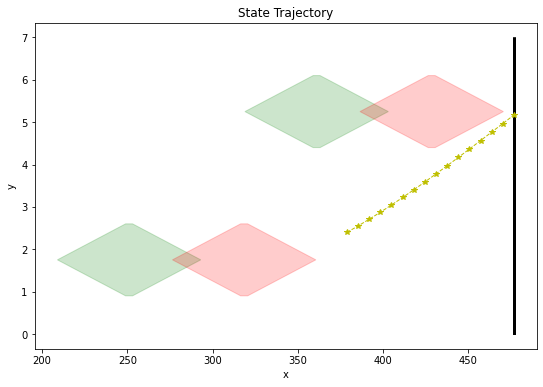

SV Lane Info :  [1, 1]
LV info :  [-1, 0]
58 th step ended
---------------------------------------------------------------------
0th successor calculation
1th successor calculation
2th successor calculation
3th successor calculation
4th successor calculation
5th successor calculation
6th successor calculation
7th successor calculation
8th successor calculation
9th successor calculation
10th successor calculation
11th successor calculation
12th successor calculation
13th successor calculation
14th successor calculation
[[  483.24695   483.25695   483.26695 ...   483.24695   483.25695
    483.26695]
 [    0.01        0.01        0.01    ...     6.98        6.98
      6.98   ]
 [15036.0232  15036.0232  15036.0232  ...  3786.00081  3786.00081
   3786.00081]]
risk value :  0.6458671964406718


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:68: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


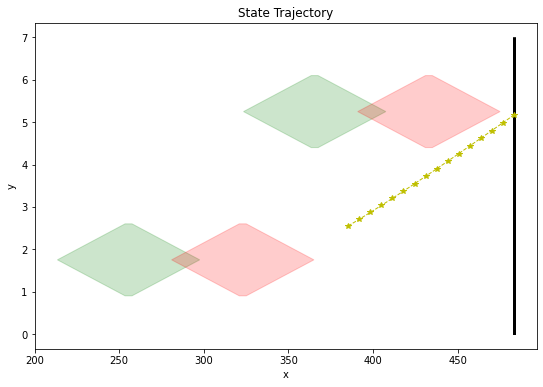

SV Lane Info :  [1, 1]
LV info :  [-1, 0]
59 th step ended
---------------------------------------------------------------------
0th successor calculation
1th successor calculation
2th successor calculation
3th successor calculation
4th successor calculation
5th successor calculation
6th successor calculation
7th successor calculation
8th successor calculation
9th successor calculation
10th successor calculation
11th successor calculation
12th successor calculation
13th successor calculation
14th successor calculation
[[  489.77307   489.78307   489.79307 ...   489.77307   489.78307
    489.79307]
 [    0.01        0.01        0.01    ...     6.98        6.98
      6.98   ]
 [15036.0232  15036.0232  15036.0232  ...  3786.00081  3786.00081
   3786.00081]]
risk value :  0.6458671964406718


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:68: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


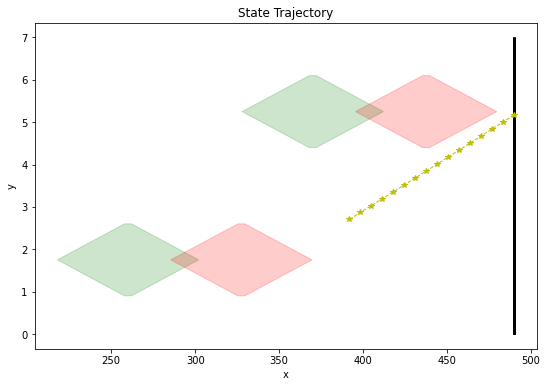

SV Lane Info :  [1, 1]
LV info :  [-1, 0]
60 th step ended
---------------------------------------------------------------------
0th successor calculation
1th successor calculation
2th successor calculation
3th successor calculation
4th successor calculation
5th successor calculation
6th successor calculation
7th successor calculation
8th successor calculation
9th successor calculation
10th successor calculation
11th successor calculation
12th successor calculation
13th successor calculation
14th successor calculation
[[  496.29904   496.30904   496.31904 ...   496.29904   496.30904
    496.31904]
 [    0.01        0.01        0.01    ...     6.98        6.98
      6.98   ]
 [15036.0232  15036.0232  15036.0232  ...  3786.00081  3786.00081
   3786.00081]]
risk value :  0.6458671964406718


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:68: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


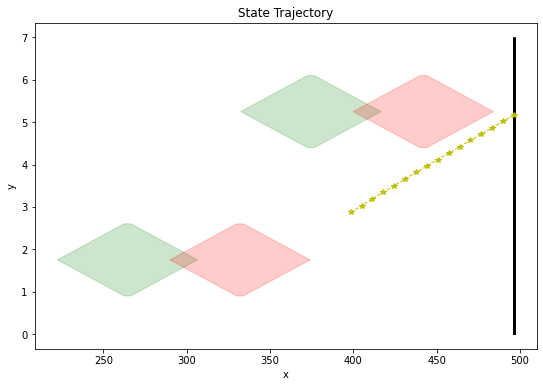

SV Lane Info :  [1, 1]
LV info :  [-1, 0]
61 th step ended
---------------------------------------------------------------------
0th successor calculation
1th successor calculation
2th successor calculation
3th successor calculation
4th successor calculation
5th successor calculation
6th successor calculation
7th successor calculation
8th successor calculation
9th successor calculation
10th successor calculation
11th successor calculation
12th successor calculation
13th successor calculation
14th successor calculation
[[  502.82492   502.83492   502.84492 ...   502.82492   502.83492
    502.84492]
 [    0.01        0.01        0.01    ...     6.98        6.98
      6.98   ]
 [15036.0232  15036.0232  15036.0232  ...  3786.00081  3786.00081
   3786.00081]]
risk value :  0.6458671964406718


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:68: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


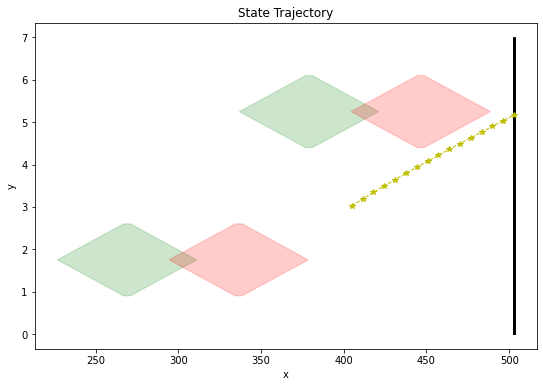

SV Lane Info :  [1, 1]
LV info :  [-1, 0]
62 th step ended
---------------------------------------------------------------------
0th successor calculation
1th successor calculation
2th successor calculation
3th successor calculation
4th successor calculation
5th successor calculation
6th successor calculation
7th successor calculation
8th successor calculation
9th successor calculation
10th successor calculation
11th successor calculation
12th successor calculation
13th successor calculation
14th successor calculation
[[  509.35076   509.36076   509.37076 ...   509.35076   509.36076
    509.37076]
 [    0.01        0.01        0.01    ...     6.98        6.98
      6.98   ]
 [15036.0232  15036.0232  15036.0232  ...  3786.00081  3786.00081
   3786.00081]]
risk value :  0.6458671964406718


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:68: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


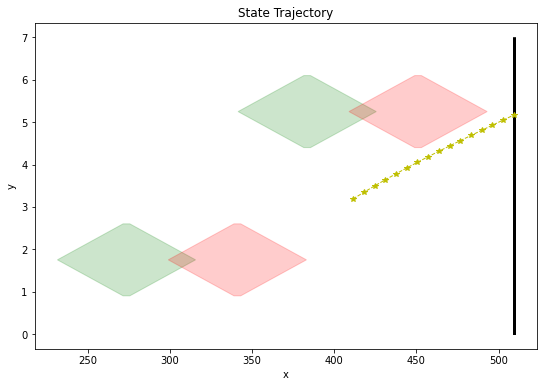

SV Lane Info :  [1, 1]
LV info :  [-1, 0]
63 th step ended
---------------------------------------------------------------------
0th successor calculation
1th successor calculation
2th successor calculation
3th successor calculation
4th successor calculation
5th successor calculation
6th successor calculation
7th successor calculation
8th successor calculation
9th successor calculation
10th successor calculation
11th successor calculation
12th successor calculation
13th successor calculation
14th successor calculation
[[  515.87663   515.88663   515.89663 ...   515.87663   515.88663
    515.89663]
 [    0.01        0.01        0.01    ...     6.98        6.98
      6.98   ]
 [15036.0232  15036.0232  15036.0232  ...  3786.00081  3786.00081
   3786.00081]]
risk value :  0.6458671964406718


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:68: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


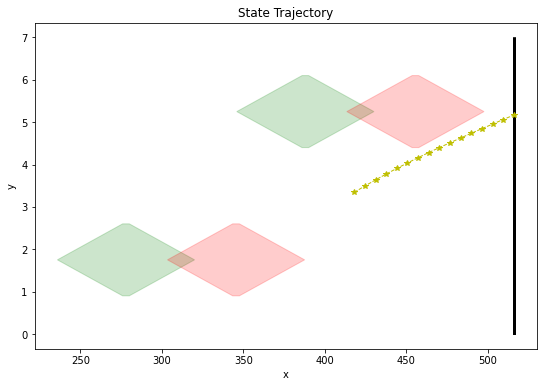

SV Lane Info :  [1, 1]
LV info :  [-1, 0]
64 th step ended
---------------------------------------------------------------------
0th successor calculation
1th successor calculation
2th successor calculation
3th successor calculation
4th successor calculation
5th successor calculation
6th successor calculation
7th successor calculation
8th successor calculation
9th successor calculation
10th successor calculation
11th successor calculation
12th successor calculation
13th successor calculation
14th successor calculation
[[  522.40253   522.41253   522.42253 ...   522.40253   522.41253
    522.42253]
 [    0.01        0.01        0.01    ...     6.98        6.98
      6.98   ]
 [15036.0232  15036.0232  15036.0232  ...  3786.00081  3786.00081
   3786.00081]]
risk value :  0.6458671964406718


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:68: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


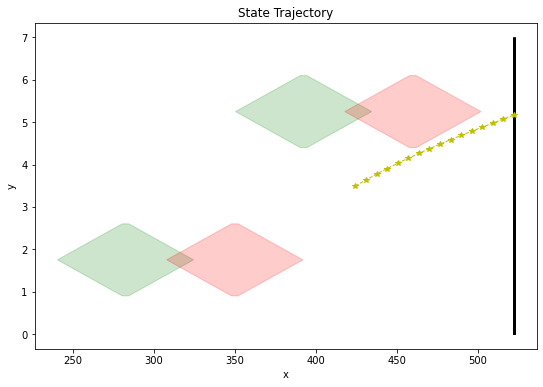

SV Lane Info :  [1, 1]
LV info :  [-1, 0]
65 th step ended
---------------------------------------------------------------------
0th successor calculation
1th successor calculation
2th successor calculation
3th successor calculation
4th successor calculation
5th successor calculation
6th successor calculation
7th successor calculation
8th successor calculation
9th successor calculation
10th successor calculation
11th successor calculation
12th successor calculation
13th successor calculation
14th successor calculation
[[  528.92849   528.93849   528.94849 ...   528.92849   528.93849
    528.94849]
 [    0.01        0.01        0.01    ...     6.98        6.98
      6.98   ]
 [15036.0232  15036.0232  15036.0232  ...  3786.00081  3786.00081
   3786.00081]]
risk value :  0.6458671964406718


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:68: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


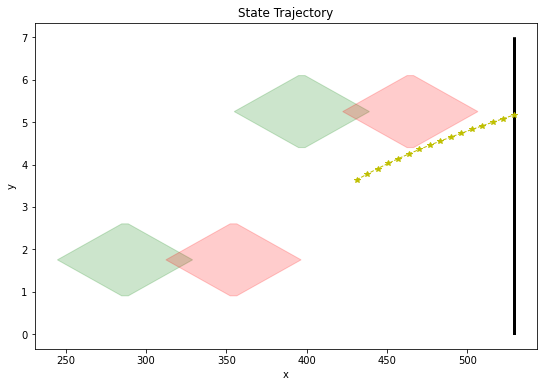

SV Lane Info :  [1, 1]
LV info :  [-1, 0]
66 th step ended
---------------------------------------------------------------------
0th successor calculation
1th successor calculation
2th successor calculation
3th successor calculation
4th successor calculation
5th successor calculation
6th successor calculation
7th successor calculation
8th successor calculation
9th successor calculation
10th successor calculation
11th successor calculation
12th successor calculation
13th successor calculation
14th successor calculation
[[  535.45452   535.46452   535.47452 ...   535.45452   535.46452
    535.47452]
 [    0.01        0.01        0.01    ...     6.98        6.98
      6.98   ]
 [15036.0232  15036.0232  15036.0232  ...  3786.00081  3786.00081
   3786.00081]]
risk value :  0.6458671964406718


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:68: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


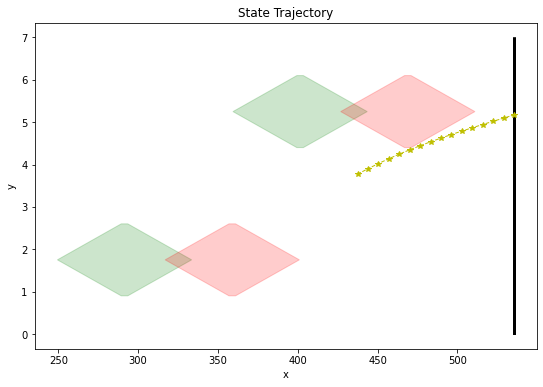

SV Lane Info :  [1, 1]
LV info :  [-1, 0]
67 th step ended
---------------------------------------------------------------------
0th successor calculation
1th successor calculation
2th successor calculation
3th successor calculation
4th successor calculation
5th successor calculation
6th successor calculation
7th successor calculation
8th successor calculation
9th successor calculation
10th successor calculation
11th successor calculation
12th successor calculation
13th successor calculation
14th successor calculation
[[  541.98063   541.99063   542.00063 ...   541.98063   541.99063
    542.00063]
 [    0.01        0.01        0.01    ...     6.98        6.98
      6.98   ]
 [15036.0232  15036.0232  15036.0232  ...  3786.00081  3786.00081
   3786.00081]]
risk value :  0.6458671964406718


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:68: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


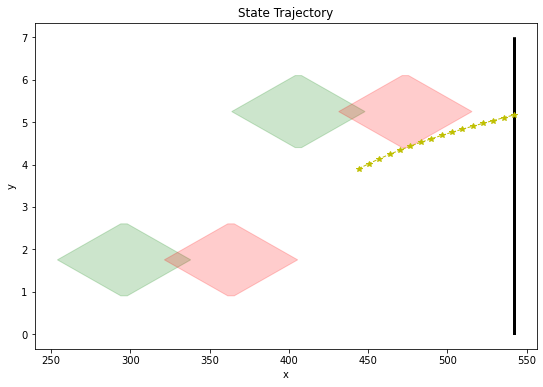

SV Lane Info :  [1, 1]
LV info :  [-1, 0]
68 th step ended
---------------------------------------------------------------------
0th successor calculation
1th successor calculation
2th successor calculation
3th successor calculation
4th successor calculation
5th successor calculation
6th successor calculation
7th successor calculation
8th successor calculation
9th successor calculation
10th successor calculation
11th successor calculation
12th successor calculation
13th successor calculation
14th successor calculation
[[  548.5068    548.5168    548.5268  ...   548.5068    548.5168
    548.5268 ]
 [    0.01        0.01        0.01    ...     6.98        6.98
      6.98   ]
 [15036.0232  15036.0232  15036.0232  ...  3786.00081  3786.00081
   3786.00081]]
risk value :  0.6458671964406718


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:68: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


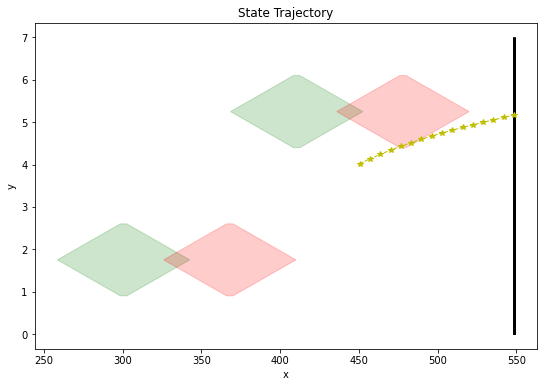

SV Lane Info :  [1, 1]
LV info :  [-1, 0]
69 th step ended
---------------------------------------------------------------------
0th successor calculation
1th successor calculation
2th successor calculation
3th successor calculation
4th successor calculation
5th successor calculation
6th successor calculation
7th successor calculation
8th successor calculation
9th successor calculation
10th successor calculation
11th successor calculation
12th successor calculation
13th successor calculation
14th successor calculation
[[  555.03303   555.04303   555.05303 ...   555.03303   555.04303
    555.05303]
 [    0.01        0.01        0.01    ...     6.98        6.98
      6.98   ]
 [15036.0232  15036.0232  15036.0232  ...  3786.00081  3786.00081
   3786.00081]]
risk value :  0.6458671964406718


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:68: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


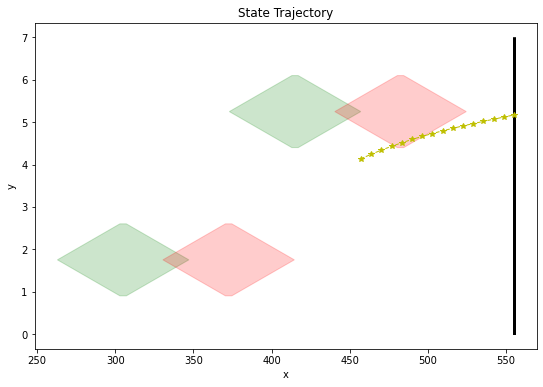

SV Lane Info :  [1, 1]
LV info :  [-1, 0]
70 th step ended
---------------------------------------------------------------------
0th successor calculation
1th successor calculation
2th successor calculation
3th successor calculation
4th successor calculation
5th successor calculation
6th successor calculation
7th successor calculation
8th successor calculation
9th successor calculation
10th successor calculation
11th successor calculation
12th successor calculation
13th successor calculation
14th successor calculation
[[  561.55932   561.56932   561.57932 ...   561.55932   561.56932
    561.57932]
 [    0.01        0.01        0.01    ...     6.98        6.98
      6.98   ]
 [15036.0232  15036.0232  15036.0232  ...  3786.00081  3786.00081
   3786.00081]]
risk value :  0.6458671964406718


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:68: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


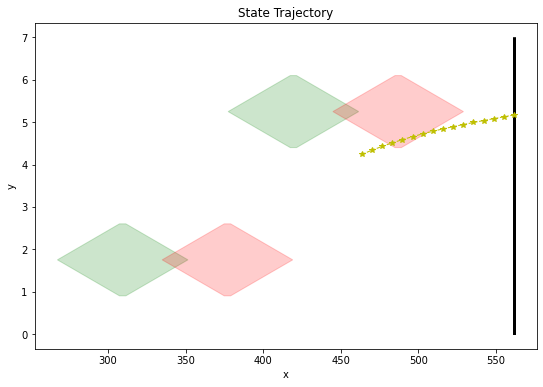

SV Lane Info :  [1, 1]
LV info :  [-1, 0]
71 th step ended
---------------------------------------------------------------------
0th successor calculation
1th successor calculation
2th successor calculation
3th successor calculation
4th successor calculation
5th successor calculation
6th successor calculation
7th successor calculation
8th successor calculation
9th successor calculation
10th successor calculation
11th successor calculation
12th successor calculation
13th successor calculation
14th successor calculation
[[  568.08565   568.09565   568.10565 ...   568.08565   568.09565
    568.10565]
 [    0.01        0.01        0.01    ...     6.98        6.98
      6.98   ]
 [15036.0232  15036.0232  15036.0232  ...  3786.00081  3786.00081
   3786.00081]]
risk value :  0.6458671964406718


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:68: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


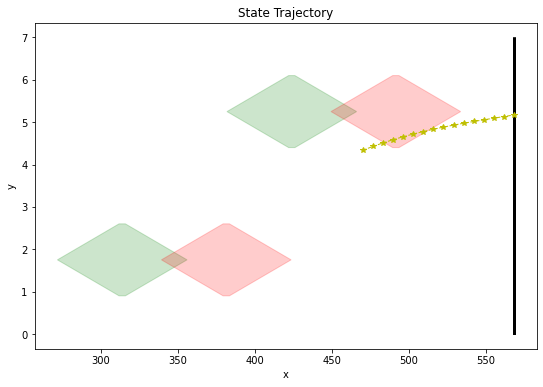

SV Lane Info :  [1, 1]
LV info :  [-1, 0]
72 th step ended
---------------------------------------------------------------------
0th successor calculation
1th successor calculation
2th successor calculation
3th successor calculation
4th successor calculation
5th successor calculation
6th successor calculation
7th successor calculation
8th successor calculation
9th successor calculation
10th successor calculation
11th successor calculation
12th successor calculation
13th successor calculation
14th successor calculation
[[  574.61201   574.62201   574.63201 ...   574.61201   574.62201
    574.63201]
 [    0.01        0.01        0.01    ...     6.98        6.98
      6.98   ]
 [15036.0232  15036.0232  15036.0232  ...  3786.00081  3786.00081
   3786.00081]]
risk value :  0.6458671964406718


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:68: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


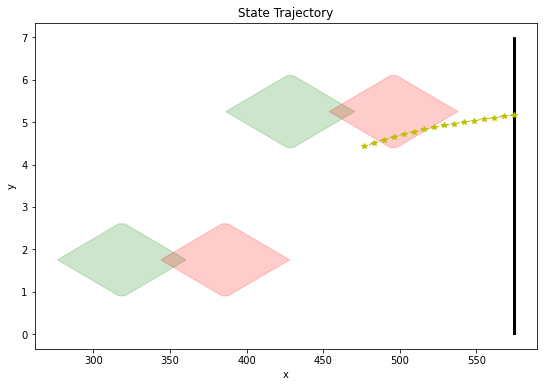

SV Lane Info :  [1, 1]
LV info :  [-1, 0]
73 th step ended
---------------------------------------------------------------------
0th successor calculation
1th successor calculation
2th successor calculation
3th successor calculation
4th successor calculation
5th successor calculation
6th successor calculation
7th successor calculation
8th successor calculation
9th successor calculation
10th successor calculation
11th successor calculation
12th successor calculation
13th successor calculation
14th successor calculation
[[  581.13838   581.14838   581.15838 ...   581.13838   581.14838
    581.15838]
 [    0.01        0.01        0.01    ...     6.98        6.98
      6.98   ]
 [15036.0232  15036.0232  15036.0232  ...  3786.00081  3786.00081
   3786.00081]]
risk value :  0.6458671964406718


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:68: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


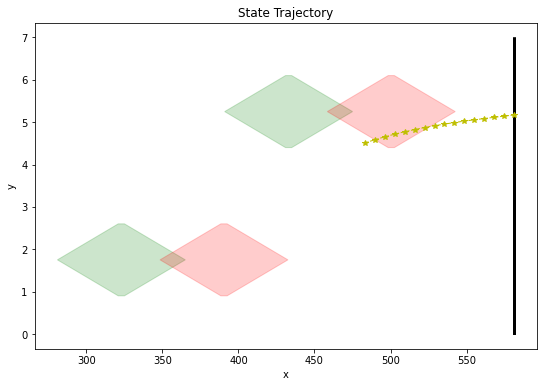

SV Lane Info :  [1, 1]
LV info :  [-1, 0]
74 th step ended
---------------------------------------------------------------------
0th successor calculation
1th successor calculation
2th successor calculation
3th successor calculation
4th successor calculation
5th successor calculation
6th successor calculation
7th successor calculation
8th successor calculation
9th successor calculation
10th successor calculation
11th successor calculation
12th successor calculation
13th successor calculation
14th successor calculation
[[  587.66476   587.67476   587.68476 ...   587.66476   587.67476
    587.68476]
 [    0.01        0.01        0.01    ...     6.98        6.98
      6.98   ]
 [15036.0232  15036.0232  15036.0232  ...  3786.00081  3786.00081
   3786.00081]]
risk value :  0.6458671964406718


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:68: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


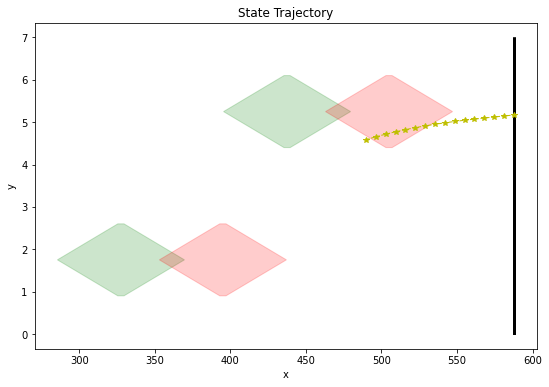

SV Lane Info :  [1, 1]
LV info :  [-1, 0]
75 th step ended
---------------------------------------------------------------------
0th successor calculation
1th successor calculation
2th successor calculation
3th successor calculation
4th successor calculation
5th successor calculation
6th successor calculation
7th successor calculation
8th successor calculation
9th successor calculation
10th successor calculation
11th successor calculation
12th successor calculation
13th successor calculation
14th successor calculation
[[ 594.19113  594.20113  594.21113 ...  594.19113  594.20113  594.21113]
 [   0.04611    0.04611    0.04611 ...    6.98611    6.98611    6.98611]
 [ 741.3862   741.3862   741.3862  ... 7810.48971 7810.48971 7810.48971]]
risk value :  0.6458364869022557


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:68: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


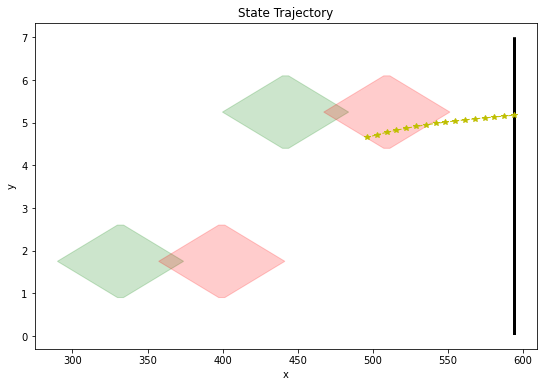

SV Lane Info :  [1, 1]
LV info :  [-1, 0]
76 th step ended
---------------------------------------------------------------------
0th successor calculation
1th successor calculation
2th successor calculation
3th successor calculation
4th successor calculation
5th successor calculation
6th successor calculation
7th successor calculation
8th successor calculation
9th successor calculation
10th successor calculation
11th successor calculation
12th successor calculation
13th successor calculation
14th successor calculation
[[ 600.71748  600.72748  600.73748 ...  600.71748  600.72748  600.73748]
 [   0.1038     0.1038     0.1038  ...    6.9838     6.9838     6.9838 ]
 [ 174.44446  174.44446  174.44446 ... 5753.35537 5753.35537 5753.35537]]
risk value :  0.6458157538085338


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:68: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


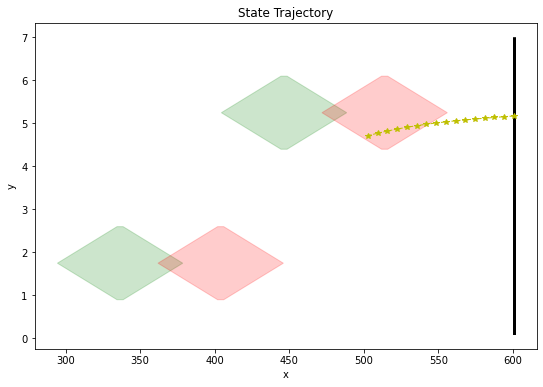

SV Lane Info :  [1, 1]
LV info :  [-1, 0]
77 th step ended
---------------------------------------------------------------------
0th successor calculation
1th successor calculation
2th successor calculation
3th successor calculation
4th successor calculation
5th successor calculation
6th successor calculation
7th successor calculation
8th successor calculation
9th successor calculation
10th successor calculation
11th successor calculation
12th successor calculation
13th successor calculation
14th successor calculation
[[ 607.24381  607.25381  607.26381 ...  607.24381  607.25381  607.26381]
 [   0.15587    0.15587    0.15587 ...    6.98587    6.98587    6.98587]
 [  95.99331   95.99331   95.99331 ... 7552.24658 7552.24658 7552.24658]]
risk value :  0.6458325614676498


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:68: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


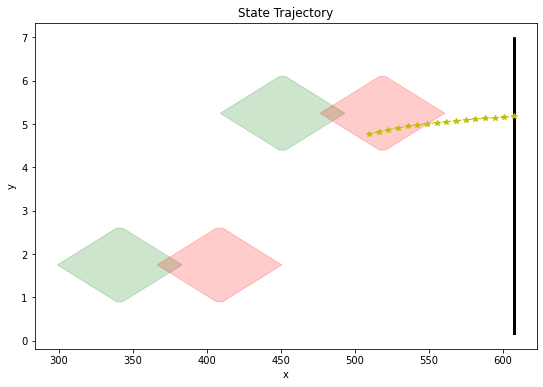

SV Lane Info :  [1, 1]
LV info :  [-1, 0]
78 th step ended
---------------------------------------------------------------------
0th successor calculation
1th successor calculation
2th successor calculation
3th successor calculation
4th successor calculation
5th successor calculation
6th successor calculation
7th successor calculation
8th successor calculation
9th successor calculation
10th successor calculation
11th successor calculation
12th successor calculation
13th successor calculation
14th successor calculation
[[ 613.7701   613.7801   613.7901  ...  613.7701   613.7801   613.7901 ]
 [   0.20274    0.20274    0.20274 ...    6.98274    6.98274    6.98274]
 [  69.57417   69.57417   69.57417 ... 5068.4944  5068.4944  5068.4944 ]]
risk value :  0.6458194119461381


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:68: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


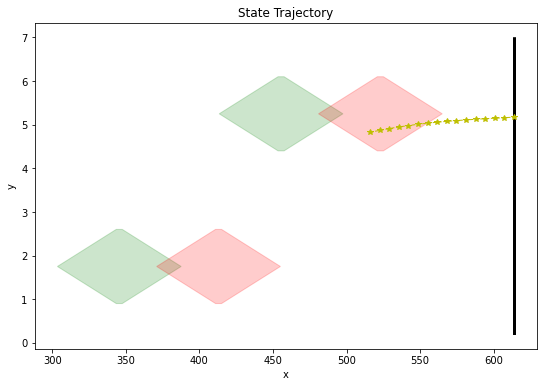

SV Lane Info :  [1, 1]
LV info :  [-1, 0]
79 th step ended
---------------------------------------------------------------------
0th successor calculation
1th successor calculation
2th successor calculation
3th successor calculation
4th successor calculation
5th successor calculation
6th successor calculation
7th successor calculation
8th successor calculation
9th successor calculation
10th successor calculation
11th successor calculation
12th successor calculation
13th successor calculation
14th successor calculation
[[ 620.29635  620.30635  620.31635 ...  620.29635  620.30635  620.31635]
 [   0.24472    0.24472    0.24472 ...    6.98472    6.98472    6.98472]
 [  56.85806   56.85806   56.85806 ... 6462.6285  6462.6285  6462.6285 ]]
risk value :  0.6458193302024888


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:68: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


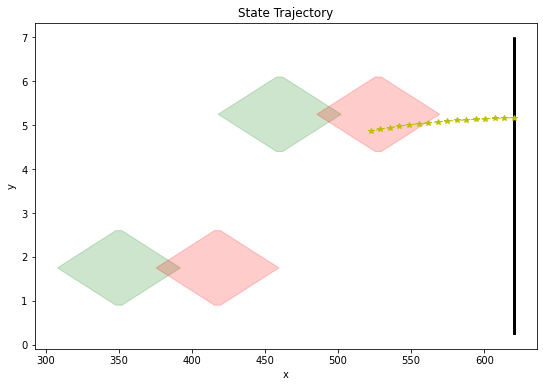

SV Lane Info :  [1, 1]
LV info :  [-1, 0]
80 th step ended
---------------------------------------------------------------------
0th successor calculation
1th successor calculation
2th successor calculation
3th successor calculation
4th successor calculation
5th successor calculation
6th successor calculation
7th successor calculation
8th successor calculation
9th successor calculation
10th successor calculation
11th successor calculation
12th successor calculation
13th successor calculation
14th successor calculation
[[ 626.82255  626.83255  626.84255 ...  626.82255  626.83255  626.84255]
 [   0.28224    0.28224    0.28224 ...    6.98224    6.98224    6.98224]
 [  49.36063   49.36063   49.36063 ... 4791.13624 4791.13624 4791.13624]]
risk value :  0.6458239751468903


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:68: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


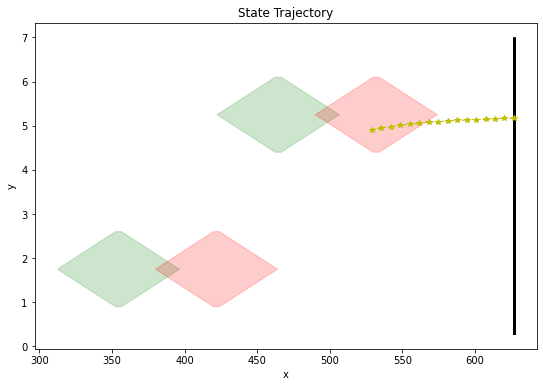

SV Lane Info :  [1, 1]
LV info :  [-1, 0]
81 th step ended
---------------------------------------------------------------------
0th successor calculation
1th successor calculation
2th successor calculation
3th successor calculation
4th successor calculation
5th successor calculation
6th successor calculation
7th successor calculation
8th successor calculation
9th successor calculation
10th successor calculation
11th successor calculation
12th successor calculation
13th successor calculation
14th successor calculation
[[ 633.34869  633.35869  633.36869 ...  633.34869  633.35869  633.36869]
 [   0.31561    0.31561    0.31561 ...    6.98561    6.98561    6.98561]
 [  44.34811   44.34811   44.34811 ... 7281.75783 7281.75783 7281.75783]]
risk value :  0.6458287041208012


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:68: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


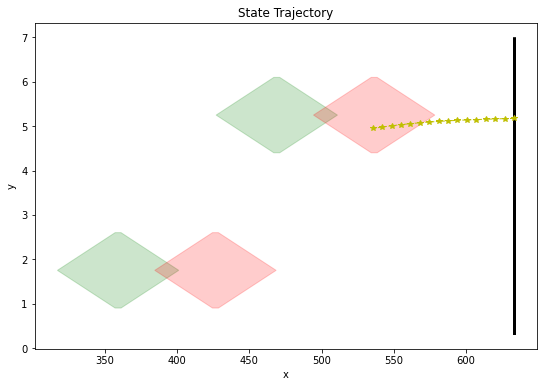

SV Lane Info :  [1, 1]
LV info :  [-1, 0]
82 th step ended
---------------------------------------------------------------------
0th successor calculation
1th successor calculation
2th successor calculation
3th successor calculation
4th successor calculation
5th successor calculation
6th successor calculation
7th successor calculation
8th successor calculation
9th successor calculation
10th successor calculation
11th successor calculation
12th successor calculation
13th successor calculation
14th successor calculation
[[ 639.87478  639.88478  639.89478 ...  639.87478  639.88478  639.89478]
 [   0.34524    0.34524    0.34524 ...    6.98524    6.98524    6.98524]
 [  40.70582   40.70582   40.70582 ... 6921.01458 6921.01458 6921.01458]]
risk value :  0.6458240752300293


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:68: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


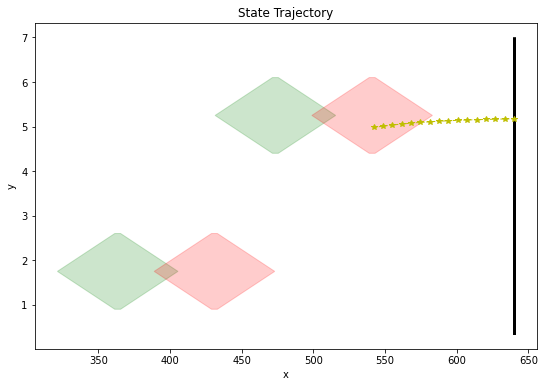

SV Lane Info :  [1, 1]
LV info :  [-1, 0]
83 th step ended
---------------------------------------------------------------------
0th successor calculation
1th successor calculation
2th successor calculation
3th successor calculation
4th successor calculation
5th successor calculation
6th successor calculation
7th successor calculation
8th successor calculation
9th successor calculation
10th successor calculation
11th successor calculation
12th successor calculation
13th successor calculation
14th successor calculation
[[ 646.4008   646.4108   646.4208  ...  646.4008   646.4108   646.4208 ]
 [   0.37144    0.37144    0.37144 ...    6.98144    6.98144    6.98144]
 [  37.91582   37.91582   37.91582 ... 4392.36059 4392.36059 4392.36059]]
risk value :  0.6458350763896463


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:68: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


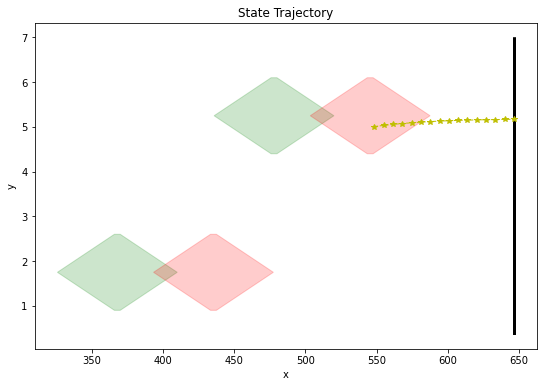

SV Lane Info :  [1, 1]
LV info :  [-1, 0]
84 th step ended
---------------------------------------------------------------------
0th successor calculation
1th successor calculation
2th successor calculation
3th successor calculation
4th successor calculation
5th successor calculation
6th successor calculation
7th successor calculation
8th successor calculation
9th successor calculation
10th successor calculation
11th successor calculation
12th successor calculation
13th successor calculation
14th successor calculation
[[ 652.92675  652.93675  652.94675 ...  652.92675  652.93675  652.94675]
 [   0.39448    0.39448    0.39448 ...    6.98448    6.98448    6.98448]
 [  35.70865   35.70865   35.70865 ... 6266.36833 6266.36833 6266.36833]]
risk value :  0.6458178037426248


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:68: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


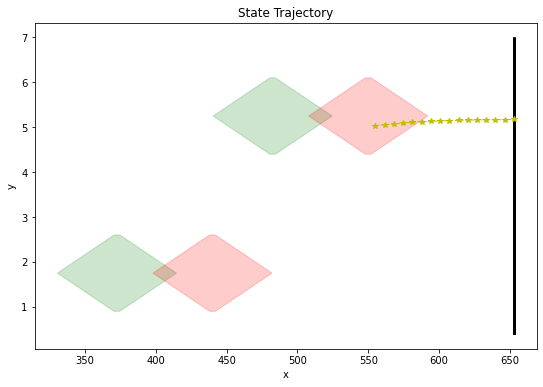

SV Lane Info :  [1, 1]
LV info :  [-1, 0]
85 th step ended
---------------------------------------------------------------------
0th successor calculation
1th successor calculation
2th successor calculation
3th successor calculation
4th successor calculation
5th successor calculation
6th successor calculation
7th successor calculation
8th successor calculation
9th successor calculation
10th successor calculation
11th successor calculation
12th successor calculation
13th successor calculation
14th successor calculation
[[ 659.45264  659.46264  659.47264 ...  659.45264  659.46264  659.47264]
 [   0.4147     0.4147     0.4147  ...    6.9847     6.9847     6.9847 ]
 [  33.91965   33.91965   33.91965 ... 6447.07025 6447.07025 6447.07025]]
risk value :  0.6458191967575809


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:68: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


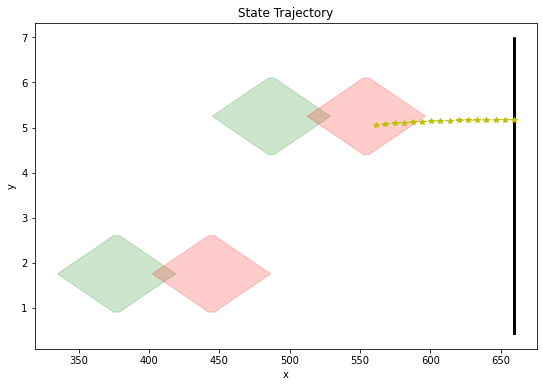

SV Lane Info :  [1, 1]
LV info :  [-1, 0]
86 th step ended
---------------------------------------------------------------------
0th successor calculation
1th successor calculation
2th successor calculation
3th successor calculation
4th successor calculation
5th successor calculation
6th successor calculation
7th successor calculation
8th successor calculation
9th successor calculation
10th successor calculation
11th successor calculation
12th successor calculation
13th successor calculation
14th successor calculation
[[ 665.97845  665.98845  665.99845 ...  665.97845  665.98845  665.99845]
 [   0.43238    0.43238    0.43238 ...    6.98238    6.98238    6.98238]
 [  32.44859   32.44859   32.44859 ... 4868.79038 4868.79038 4868.79038]]
risk value :  0.645822471341747


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:68: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


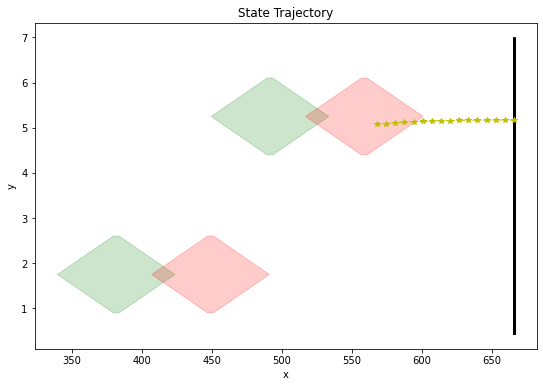

SV Lane Info :  [1, 1]
LV info :  [-1, 0]
87 th step ended
---------------------------------------------------------------------
0th successor calculation
1th successor calculation
2th successor calculation
3th successor calculation
4th successor calculation
5th successor calculation
6th successor calculation
7th successor calculation
8th successor calculation
9th successor calculation
10th successor calculation
11th successor calculation
12th successor calculation
13th successor calculation
14th successor calculation
[[  672.50419   672.51419   672.52419 ...   672.50419   672.51419
    672.52419]
 [    0.44774     0.44774     0.44774 ...     6.98774     6.98774
      6.98774]
 [   31.23063    31.23063    31.23063 ... 10019.61633 10019.61633
  10019.61633]]
risk value :  0.6458747597320309


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:68: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


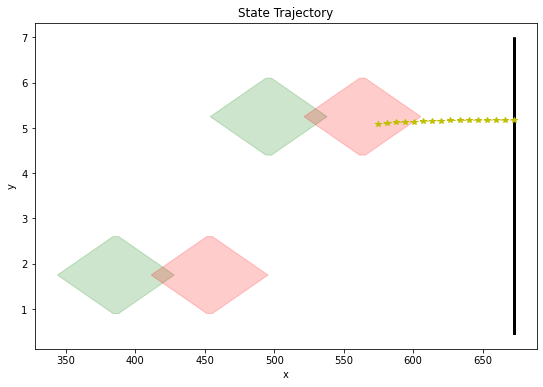

SV Lane Info :  [1, 1]
LV info :  [-1, 0]
88 th step ended
---------------------------------------------------------------------
0th successor calculation
1th successor calculation
2th successor calculation
3th successor calculation
4th successor calculation
5th successor calculation
6th successor calculation
7th successor calculation
8th successor calculation
9th successor calculation
10th successor calculation
11th successor calculation
12th successor calculation
13th successor calculation
14th successor calculation
[[ 679.02986  679.03986  679.04986 ...  679.02986  679.03986  679.04986]
 [   0.4611     0.4611     0.4611  ...    6.9811     6.9811     6.9811 ]
 [  30.21147   30.21147   30.21147 ... 4235.75178 4235.75178 4235.75178]]
risk value :  0.645841304483932


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:68: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


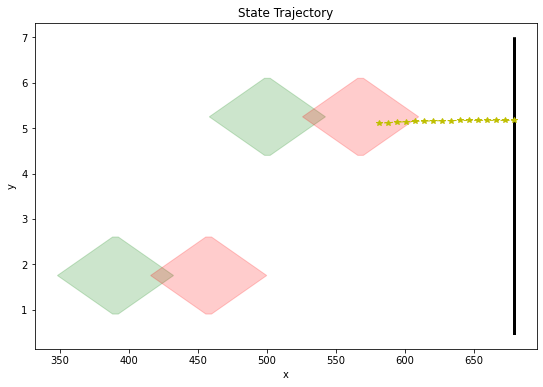

SV Lane Info :  [1, 1]
LV info :  [-1, 0]
89 th step ended
---------------------------------------------------------------------
Feasiblilty :  [ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True]
[[  0.        6.534    13.06792  19.60176  26.13551  32.66919  39.20279
   45.7363   52.26973  58.80309  65.33636  71.86955  78.40266  84.93569
   91.46864  98.00151 104.5343  111.067   117.59962 124.1319  130.66372
  137.19504 143.72589 150.25636 156.78654 163.31651 169.84636 176.37615
  182.90594 189.435

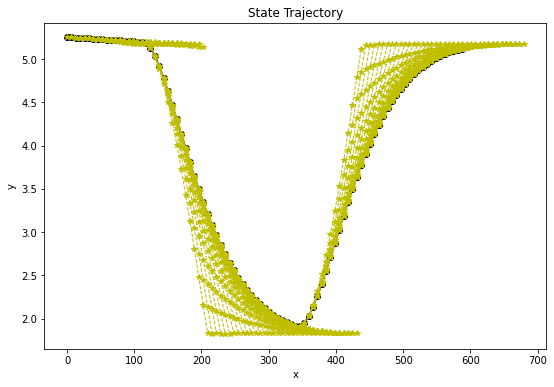

In [52]:
############ Initialize the system #################
U_safe = 0.66
sampling_time = 0.2
N = 15
SV = Subject_vehicle(SV_initial_x, SV_initial_y, SV_initial_psi)
LV1 = Lead_vehicle(LV_initialize[0,0], LV_initialize[1,0], LV_initialize[2,0])
LV2 = Lead_vehicle(LV_initialize[0,1], LV_initialize[1,1], LV_initialize[2,1])
LV3 = Lead_vehicle(LV_initialize[0,2], LV_initialize[1,2], LV_initialize[2,2])
LV_list = [LV1, LV2, LV3]
####################################################

# Q, R is defined above
# A = SV.A
# B = SV.B
P = np.eye(4)
x0 = SV.getState()
# xL = -15
# xU = 15
# uL = -1
# uU = 1
M = 90  # 165
feas = np.zeros((M), dtype=bool)
xOpt = np.zeros((np.size(SV.A,1), M+1))
xPred = np.zeros((3, N+1, M))
LV1_pos = np.zeros((2, M+1))
LV2_pos = np.zeros((2, M+1))
LV3_pos = np.zeros((2, M+1))
LV1_pos_pred = np.zeros((2, M+1))
LV2_pos_pred = np.zeros((2, M+1))
LV3_pos_pred = np.zeros((2, M+1))
target_point = np.zeros((3, M))

xOpt[:,0] = x0
LV1_pos[:,0] = LV1.getPosition()
LV2_pos[:,0] = LV2.getPosition()
LV3_pos[:,0] = LV3.getPosition()
LV1_pos_pred[:,0] = LV1.getPosition_predict()
LV2_pos_pred[:,0] = LV2.getPosition_predict()
LV3_pos_pred[:,0] = LV3.getPosition_predict()

uOpt = np.zeros((np.size(SV.B,1), M))
# predErr = np.zeros((2, M-N+1))
# xPred = np.zeros((2, N+1, M))

# TODO : obtain P
...

for t in range(M) :
  #### Get Target Point ####
  # Get meshgrid on the reachable set 
  # print(xOpt[:,:t+1])
  surround_LV_info = detect_LV(SV, LV_list)
  reachable_set = get_reachable_set(xOpt[0,t], xOpt[1,t], xOpt[2,t], xOpt[3,t], sampling_time, N)
  # bug appeared
  # X = reachable_set.project([1,2])
  # print(X)
  tmp = pt.extreme(reachable_set)
  x_max = np.amax(tmp[:,0])
  x_min = np.amin(tmp[:,0])
  y_max = np.amax(tmp[:,1])
  y_min = np.amin(tmp[:,1])
  X = pt.box2poly([[x_min, x_max], [y_min, y_max]])
  xx, yy = get_point_in_2D_bbox(reachable_set)
  
  # Make risk map
  risk_map = np.zeros((3,xx.size))
  index = 0
  for i in range(xx.shape[0]) :
    for j in range(xx.shape[1]) :
      risk_map[0,index] = xx[i,j]
      risk_map[1,index] = yy[i,j]
      risk_map[2,index] = risk_value(np.array([xx[i,j], yy[i,j]]), LV1, LV2, LV3, True) # modified : car_potential_off = True
      index += 1
  print(risk_map)

  # Get target point from the risk map. The output is [x_target, y_target, risk_value]
  target_state = get_target_state(risk_map, xOpt[0,t])
  print('risk value : ', target_state[4])

  # Set Terminal Constraint - Af, bf. For now, our terminal constraint forces the system to go to x_target and y_target. (i.e. doesn't matter psi and v)
  # Af = np.array([[1.0,0,0,0], [-1.0,0,0,0], [0,1.0,0,0], [0,-1.0,0,0], 
                #  [0,0,1.0,0], [0,0,-1.0,0], [0,0,0,1.0], [0,0,0,-1.0]])
  Af = np.array([[1.0,0], [-1.0,0], [0,1.0], [0,-1.0]])
  bf = target_state[:4]

  [fea, x, u, J] = solve_cftoc_onlyCar(SV.A, SV.B, P, Q, R, N, xOpt[:,t], X_set, U_set, bf, Af, SV, surround_LV_info, LV_list, X, True)
  if not fea :
    # xOpt = []
    # uOpt = []
    break
  print(t,'th step ended')
  feas[t] = True
  xPred[:,:,t] = x[:3,:]
  SV.update_state_Notapprox(u[:,0])  # modified update_state_approx
  LV1.updatePosition()
  LV2.updatePosition()
  LV3.updatePosition()
  xOpt[:,t+1] = SV.getState()
  LV1_pos[:,t+1] = LV1.getPosition()
  LV2_pos[:,t+1] = LV2.getPosition()
  LV3_pos[:,t+1] = LV3.getPosition()
  LV1_pos_pred[:,t+1] = LV1.getPosition_predict()
  LV2_pos_pred[:,t+1] = LV2.getPosition_predict()
  LV3_pos_pred[:,t+1] = LV3.getPosition_predict()
  target_point[:,t] = [target_state[0], target_state[1], target_state[4]]
  uOpt[:,t] = u[:,0]
  print('---------------------------------------------------------------------')

print('Feasiblilty : ',feas)
print(xOpt)
print(uOpt)

fig = plt.figure(figsize=(9,6))
actual = plt.plot(xOpt[0,:], xOpt[1,:], 'ko-')
for t in range(np.size(xPred,2)) :
  pred = plt.plot(xPred[0,:,t], xPred[1,:,t], 'y*--', linewidth=1)
plt.xlabel('x')
plt.ylabel('y')
plt.title('State Trajectory')
plt.show()


In [40]:
print(xOpt[:,45])
print(reachable_set)
# print(reachable_set.reduce())
print(reachable_set.project([1,2]))
print(pt.extreme(reachable_set))

[293.94811   1.83345  -0.00004  32.66826]
Single polytope 
  [[ 0.31623  0.      -0.      -0.94868] |    [[ 92.95456]
   [-0.       0.56064 -0.82806  0.     ] |     [  3.59223]
   [ 0.       0.      -0.       1.     ] |     [ 32.66836]
   [ 0.      -0.      -0.      -1.     ] |     [-32.66816]
   [-0.31623 -0.       0.       0.94868] x <=  [-92.94823]
   [-0.       0.12387 -0.9923   0.     ] |     [  0.80751]
   [ 0.      -1.       0.       0.     ] |     [  0.     ]
   [ 0.       0.       1.       0.     ] |     [  0.05   ]
   [ 0.       0.      -1.       0.     ]]|     [  0.05   ]]

Single polytope 
  [[-0.  1.] |    [[   6.48125]
   [ 0. -1.] x <=  [  -5.46471]
   [ 1.  0.] |     [ 391.9532 ]
   [-1. -0.]]|     [-391.9326 ]]

[[391.9526   -0.        0.05     32.66816]
 [391.9326   -0.        0.05     32.66816]
 [391.9532    0.        0.05     32.66836]
 [391.9332   -0.        0.05     32.66836]
 [391.9526    6.48125   0.05     32.66816]
 [391.9326    6.48125   0.05     32.66816]
 [3

[2, 2]
[2, 0]
[[ 98.0097  104.54358 111.07742 117.61072 124.14326 130.67515 137.20662
  143.73788 150.2691  156.80039 163.33184 169.8635  176.39537 182.92747
  189.45977 195.99228 202.52495 209.05778 215.59074 222.12382 228.65699
  235.19025 241.72357 248.25695 254.79037 261.32383 267.85732 274.39084
  280.92437 287.45792 293.99147 300.52503 307.0586  313.59217 320.12574
  326.65931 333.19288 339.72644 346.26    352.79356 359.32712 365.86029
  372.39276 378.9247    0.        0.        0.        0.        0.
    0.        0.        0.        0.        0.        0.        0.
    0.        0.        0.        0.        0.        0.        0.
    0.        0.        0.        0.        0.        0.        0.
    0.        0.        0.        0.        0.        0.        0.
    0.        0.        0.        0.        0.        0.        0.
    0.        0.        0.        0.        0.        0.     ]
 [  1.83      5.17      5.17      5.17      5.17      5.17      5.17
    5.17      5.17  

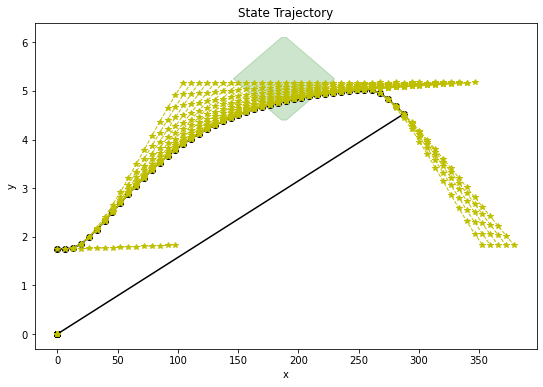

In [ ]:
print(SV.get_laneInfo())
print(detect_LV(SV, LV_list))
print(target_point)
wedge_LV1 = LV1.getWedgePoints()

fig = plt.figure(figsize=(9,6))
actual = plt.plot(xOpt[0,:], xOpt[1,:], 'ko-')
for t in range(np.size(xPred,2)) :
  pred = plt.plot(xPred[0,:,t], xPred[1,:,t], 'y*--', linewidth=1)
plt.xlabel('x')
plt.ylabel('y')
plt.title('State Trajectory')
plt.fill(wedge_LV1[:,0], wedge_LV1[:,1], alpha = 0.2, c = 'g')

plt.show()


(0.0, 350.0)

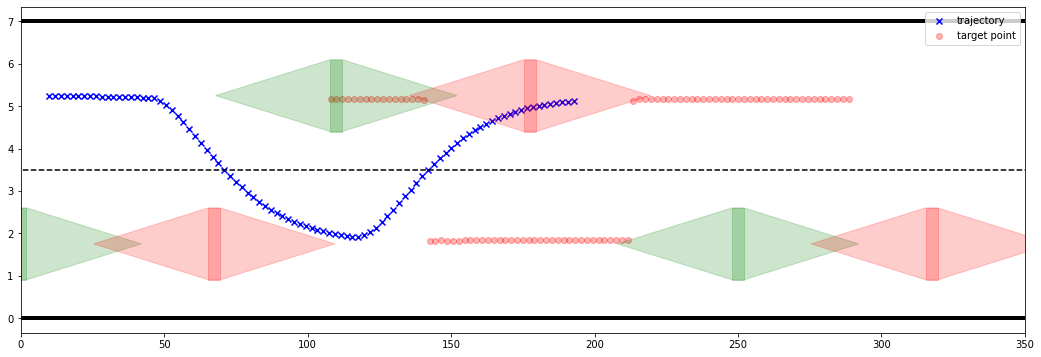

In [53]:
# print(xOpt)
# print(LV1_pos)
# print(LV2_pos)
# print(target_point)
# print(xOpt[0,:])
# print(LV1_pos[0,:])
# print(xOpt[0,:] - LV1_pos[0,:])

wedge_LV1 = LV1.getWedgePoints()
vertice_LV1 = wedge_LV1[[1,2,4,5],:]
wedge_LV2 = LV2.getWedgePoints()
vertice_LV2 = wedge_LV2[[1,2,4,5],:]
wedge_LV3 = LV3.getWedgePoints()
vertice_LV3 = wedge_LV3[[1,2,4,5],:]

wedge_LV1[:,0] = wedge_LV1[:,0] - LV1.getPosition()[0]
vertice_LV1[:,0] = vertice_LV1[:,0] - LV1.getPosition()[0]
wedge_LV2[:,0] = wedge_LV2[:,0] - LV1.getPosition()[0]
vertice_LV2[:,0] = vertice_LV2[:,0] - LV1.getPosition()[0]
wedge_LV3[:,0] = wedge_LV3[:,0] - LV1.getPosition()[0]
vertice_LV3[:,0] = vertice_LV3[:,0] - LV1.getPosition()[0]

##---- Predicted location ----##
wedge_predict_LV1 = LV1.getWedgePoints_predict()
vertice_predict_LV1 = wedge_predict_LV1[[1,2,4,5],:]
wedge_predict_LV2 = LV2.getWedgePoints_predict()
vertice_predict_LV2 = wedge_predict_LV2[[1,2,4,5],:]
wedge_predict_LV3 = LV3.getWedgePoints_predict()
vertice_predict_LV3 = wedge_predict_LV3[[1,2,4,5],:]

wedge_predict_LV1[:,0] = wedge_predict_LV1[:,0] - LV1.getPosition()[0]
vertice_predict_LV1[:,0] = vertice_predict_LV1[:,0] - LV1.getPosition()[0]
wedge_predict_LV2[:,0] = wedge_predict_LV2[:,0] - LV1.getPosition()[0]
vertice_predict_LV2[:,0] = vertice_predict_LV2[:,0] - LV1.getPosition()[0]
wedge_predict_LV3[:,0] = wedge_predict_LV3[:,0] - LV1.getPosition()[0]
vertice_predict_LV3[:,0] = vertice_predict_LV3[:,0] - LV1.getPosition()[0]
################################

fig, ax = plt.subplots(1,1, figsize=(18,6))
ax.scatter(xOpt[0,:] - LV1_pos[0,:], xOpt[1,:],  marker ='x', c = 'b')
ax.scatter(target_point[0,:] - LV1_pos[0,:-1], target_point[1,:], alpha = 0.3, marker ='o', c = 'r')
ax.legend(['trajectory', 'target point'])

ax.plot([-1000, 1000], [lane_width, lane_width], '--', c = 'k')
ax.plot([-1000, 1000], [2*lane_width, 2*lane_width], linewidth = 4, c = 'k')
ax.plot([-1000, 1000], [0, 0], linewidth = 4, c = 'k')
ax.fill(wedge_LV1[:,0], wedge_LV1[:,1], alpha = 0.2, c = 'g')
ax.fill(vertice_LV1[:,0], vertice_LV1[:,1], alpha = 0.2, c = 'g')
ax.fill(wedge_LV2[:,0], wedge_LV2[:,1], alpha = 0.2, c = 'g')
ax.fill(vertice_LV2[:,0], vertice_LV2[:,1], alpha = 0.2, c = 'g')
ax.fill(wedge_LV3[:,0], wedge_LV3[:,1], alpha = 0.2, c = 'g')
ax.fill(vertice_LV3[:,0], vertice_LV3[:,1], alpha = 0.2, c = 'g')

ax.fill(wedge_predict_LV1[:,0], wedge_predict_LV1[:,1], alpha = 0.2, c = 'r')
ax.fill(vertice_predict_LV1[:,0], vertice_predict_LV1[:,1], alpha = 0.2, c = 'r')
ax.fill(wedge_predict_LV2[:,0], wedge_predict_LV2[:,1], alpha = 0.2, c = 'r')
ax.fill(vertice_predict_LV2[:,0], vertice_predict_LV2[:,1], alpha = 0.2, c = 'r')
ax.fill(wedge_predict_LV3[:,0], wedge_predict_LV3[:,1], alpha = 0.2, c = 'r')
ax.fill(vertice_predict_LV3[:,0], vertice_predict_LV3[:,1], alpha = 0.2, c = 'r')

ax.set_xlim([xOpt[0,0] - LV1_pos[0,0] - 10, LV3.getPosition()[0] - LV1.getPosition()[0] + 100])

True


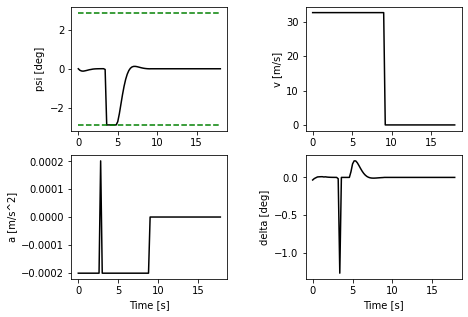

In [25]:
rad2deg = 180/np.pi
time = np.arange(0, M+1,1) * 0.2
fig, ax = plt.subplots(2,2, figsize = (7,5))
ax[0,0].plot(time, rad2deg * xOpt[2,:], 'k')
ax[0,0].plot(time, rad2deg * SV_psi_upper * np.ones(np.size(xOpt,1),), 'g--')
ax[0,0].plot(time, rad2deg * SV_psi_lower * np.ones(np.size(xOpt,1),), 'g--')
ax[0,1].plot(time, xOpt[3,:], 'k')
ax[1,0].plot(time[0:-1], uOpt[0,:], 'k')
ax[1,1].plot(time[0:-1], rad2deg * uOpt[1,:],'k')
fig.subplots_adjust(wspace=0.5)
ax[0,0].set_ylabel('psi [deg]')
ax[0,1].set_ylabel('v [m/s]')
ax[1,0].set_ylabel('a [m/s^2]')
ax[1,1].set_ylabel('delta [deg]')
ax[1,0].set_xlabel('Time [s]')
ax[1,1].set_xlabel('Time [s]')



# SV_psi_lower = -0.035
# SV_psi_upper = 0.035
# SV_v_lower = 22.5
# SV_v_upper = SV_v_desired

# SV_a_upper = 1.5 # [m/s^2]
# SV_a_lower = -1.5
# SV_delta_upper = 0.02 # [rad]
# SV_delta_lower = -0.02
print(xOpt[:,44] in X_set) 

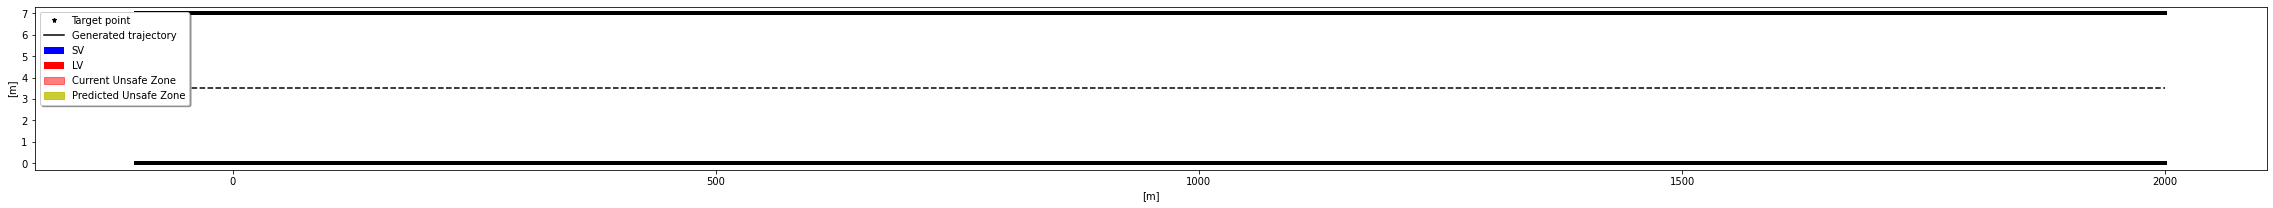

In [ ]:
################## ANIMATION #####################
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# create a figure and axes
fig = plt.figure(figsize=(40,3))
ax1 = plt.subplot(1,1,1)   

# set up the subplots as needed
# ax1.set_xlim(( 0, 2))            
ax1.set_ylim((-0.3, num_lane*lane_width+0.3))
ax1.set_xlabel('[m]')
ax1.set_ylabel('[m]')

ax1.plot([-100, 2000], [lane_width, lane_width], '--', c = 'k')
ax1.plot([-100, 2000], [2*lane_width, 2*lane_width], linewidth = 4, c = 'k')
ax1.plot([-100, 2000], [0, 0], linewidth = 4, c = 'k')

# create objects that will change in the animation. These are
# initially empty, and will be given new values for each frame
# in the animation.
txt_title = ax1.set_title('')
target_pt, = ax1.plot([], [], 'k*', ms=5)
traj_pred, = ax1.plot([], [], 'k', )
SV_anim, = ax1.fill([], [], 'b', lw=2)     # ax.plot returns a list of 2D line objects

LV1_anim, = ax1.fill([], [], 'r')
LV1_unsafe_anim, = ax1.fill([], [], alpha = 0.5, c='r')
LV1_pred_anim, = ax1.fill([], [], alpha=0.8, c='y')

LV2_anim, = ax1.fill([], [], 'r')
LV2_unsafe_anim, = ax1.fill([], [], alpha = 0.5, c='r')
LV2_pred_anim, = ax1.fill([], [], alpha=0.8, c='y')

LV3_anim, = ax1.fill([], [], 'r')
LV3_unsafe_anim, = ax1.fill([], [], alpha = 0.5, c='r')
LV3_pred_anim, = ax1.fill([], [], alpha=0.8, c='y')

ax1.legend([target_pt, traj_pred, SV_anim, LV1_anim, LV1_unsafe_anim, LV1_pred_anim],['Target point','Generated trajectory', 'SV', 'LV', 'Current Unsafe Zone', 'Predicted Unsafe Zone'],
           loc='upper left', shadow=True);

In [ ]:
'''
xOpt = np.zeros((np.size(SV.A,1), M+1))
xPred = np.zeros((3, N+1, M))
LV1_pos = np.zeros((2, M+1))
LV2_pos = np.zeros((2, M+1))
LV3_pos = np.zeros((2, M+1))
LV1_pos_pred = np.zeros((2, M+1))
LV2_pos_pred = np.zeros((2, M+1))
LV3_pos_pred = np.zeros((2, M+1))
target_point = np.zeros((3, M))
'''

def SV_draw(state) :
  l_f = SV.l_f
  l_r = SV.l_r
  car_width=1.7
  x = state[0]
  y = state[1]
  psi = state[2]
  SV_vertice_x = np.array([[x + l_f*np.cos(psi) - car_width/2*np.sin(psi),
                           x - l_r*np.cos(psi) - car_width/2*np.sin(psi),
                           x - l_r*np.cos(psi) + car_width/2*np.sin(psi),
                           x + l_f*np.cos(psi) + car_width/2*np.sin(psi)]])
  SV_vertice_y = np.array([[y + l_f*np.sin(psi) + car_width/2*np.cos(psi),
                           y - l_r*np.sin(psi) + car_width/2*np.cos(psi),
                           y - l_r*np.sin(psi) - car_width/2*np.cos(psi),
                           y + l_f*np.sin(psi) - car_width/2*np.cos(psi)]])
  SV_vertice = np.concatenate((SV_vertice_x.T, SV_vertice_y.T), axis=1)

  return SV_vertice

print(SV_draw(xOpt[:,10]))
def drawframe(n):
  ax1.set_xlim((xOpt[0,n]-20, xOpt[0,n]+120))
  target_pt.set_data(target_point[0,n], target_point[1,n])
  traj_pred.set_data(xPred[0,:,n], xPred[1,:,n]) 
  SV_anim.set_xy(SV_draw(xOpt[:,n]))

  LV1_anim.set_xy(LV1.getVertice_anim(LV1_pos[:,n]))
  LV1_unsafe_anim.set_xy(LV1.getWedgePoints_anim(LV1_pos[:,n]))
  LV1_pred_anim.set_xy(LV1.getWedgePoints_anim(LV1_pos_pred[:,n]))

  LV2_anim.set_xy(LV2.getVertice_anim(LV2_pos[:,n]))
  LV2_unsafe_anim.set_xy(LV2.getWedgePoints_anim(LV2_pos[:,n]))
  LV2_pred_anim.set_xy(LV2.getWedgePoints_anim(LV2_pos_pred[:,n]))

  LV3_anim.set_xy(LV3.getVertice_anim(LV3_pos[:,n]))
  LV3_unsafe_anim.set_xy(LV3.getWedgePoints_anim(LV3_pos[:,n]))
  LV3_pred_anim.set_xy(LV3.getWedgePoints_anim(LV3_pos_pred[:,n]))

  txt_title.set_text('Time = {0:4f}s'.format(n*0.2))
  
  return (target_pt,traj_pred)

[[66.6855   5.04771]
 [63.76588  4.90708]
 [63.84767  3.20905]
 [66.76728  3.34968]]


In [ ]:
from matplotlib import animation
from IPython.display import HTML

# blit=True re-draws only the parts that have changed.
anim = animation.FuncAnimation(fig, drawframe, frames=90, interval=300, blit=True)

HTML(anim.to_html5_video())

In [ ]:
'''
How to improve the model :
## Problem1 : Setting target point right behind of the front LV seems not reasonable intuitively 
## Problem2 : Since the cftoc design doesn't consider the risk map, the actual trajectory of SV intrudes unsafe zone of LVs. 

Here's idea to solve :
1) Problem1 : When calcuate car_potential value, let's consider predicted LV's configuration after ts*N sec (rather than considering the LV's configuration of when it was observed)
2) Problem2 : When solve cftoc, add constraint about x and y not to intrude the unsafe region. - But how?
                                                                                    - Need two information : LV in front of SV (Front obstacle), LV on the lane that SV will move to (Side obstacle) 
                                                                                    - May need three scenario : 1) changes lane (there's only Front obstacle) 2) after cross the middle line of the road, goes to steady state 
                                                                                                                3) changes lane (there are Front and Side obstacles) - refer to situation below. LV1 - Side obstacle, LV2 - Front 
                                                                                    
                                                                                    ==============================================================
                                                                                                 \   SV       \LV2
                                                                                    --------------\------------\-----------------------------------
                                                                                                LV1\          * \
                                                                                    ==============================================================
                                                                                    
                                                                                    - For each situation, constraint on x and y will be different
                                                                                    - Because extra constraints are added, X_f would better be larger
                                                                                    - For further scenario, 'there's no point whose risk value < U_safe' will be interesting
'''

In [ ]:
# UAV model
# Andrew, Thomas, Prachitesh

# def UAV_model():
v0 = 5
g = 9.81
m = 10
lx = 
ly =
lz =
# Matrices from paper
A = [(0,0,0,1,0,0,0,0,0,0,0),
     (0,0,0,0,1,0,0,0,0,0,0),
     (0,0,0,0,0,1,0,0,0,0,0),
     (0,0,0,0,0,0,0,-g,0,0,0),
     (0,0,0,0,0,0,g,0,0,0,0),
     (0,0,0,0,0,0,0,0,0,0,0),
     (0,0,0,0,0,0,0,0,1,0,0),
     (0,0,0,0,0,0,0,0,0,1,0),
     (0,0,0,0,0,0,0,0,0,0,1),
     (0,0,0,0,0,0,0,0,0,0,0),
     (0,0,0,0,0,0,0,0,0,0,0),
     (0,0,0,0,0,0,0,0,0,0,0)]

B = [(0,0,0,0),
     (0,0,0,0),
     (0,0,0,0),
     (0,0,0,0),
     (1.0/m,0,0,0),
     (0,0,0,0),
     (0,0,0,0),
     (0,0,0,0),
     (0,0,0,0),
     (0,1.0/lx,0,0),
     (0,0,1.0/ly,0),
     (0,0,0,1.0/lz)]

A = [(v0)]

# Note: need constraints on roll, pitch, yaw angles to keep small



SyntaxError: ignored

In [ ]:
import polytope as pt
import numpy as np
from __future__ import division
import pyomo.environ as pyo
import matplotlib.pyplot as plt
# %matplotlib widget

In [ ]:
# MPC, general problem from lab 8

# Things to define: A, B, P, Q, R, N, x0, xL, xU, uL, uU

# TO BE FILLED IN:
A = np.array([[1, 1],
               [0, 1]])
B = np.array([[0],
              [1]])

Q = np.eye(2)
R = 10*np.array([1]).reshape(1,1)
P = Q
N = 3
xL = -5
xU = 5
uL = -0.5
uU = 0.5
x0 = np.array([-4.5, 2])
# END OF TO BE FILLED IN SECTION


bf=np.nan
Af=np.nan

model = pyo.ConcreteModel()
model.N = N
model.nx = np.size(A, 0)
model.nu = np.size(B, 1)

# length of finite optimization problem:
model.tIDX = pyo.Set( initialize= range(model.N+1), ordered=True )  
model.xIDX = pyo.Set( initialize= range(model.nx), ordered=True )
model.uIDX = pyo.Set( initialize= range(model.nu), ordered=True )

# these are 2d arrays:
model.A = A
model.B = B
model.Q = Q
model.P = P
model.R = R

# Create state and input variables trajectory:
model.x = pyo.Var(model.xIDX, model.tIDX, bounds=(xL,xU))
model.u = pyo.Var(model.uIDX, model.tIDX, bounds=(uL,uU))

#Objective:
def objective_rule(model):
    costX = 0.0
    costU = 0.0
    costTerminal = 0.0
    for t in model.tIDX:
        for i in model.xIDX:
            for j in model.xIDX:
                if t < model.N:
                    costX += model.x[i, t] * model.Q[i, j] * model.x[j, t] 
    for t in model.tIDX:
        for i in model.uIDX:
            for j in model.uIDX:
                if t < model.N:
                    costU += model.u[i, t] * model.R[i, j] * model.u[j, t]
    for i in model.xIDX:
        for j in model.xIDX:               
            costTerminal += model.x[i, model.N] * model.P[i, j] * model.x[j, model.N]
    return costX + costU + costTerminal

model.cost = pyo.Objective(rule = objective_rule, sense = pyo.minimize)

# Constraints:
def equality_const_rule(model, i, t):
    return model.x[i, t+1] - (sum(model.A[i, j] * model.x[j, t] for j in model.xIDX)
                            +  sum(model.B[i, j] * model.u[j, t] for j in model.uIDX) ) == 0.0 if t < model.N else pyo.Constraint.Skip

model.equality_constraints = pyo.Constraint(model.xIDX, model.tIDX, rule=equality_const_rule)
model.init_const1 = pyo.Constraint(expr = model.x[0, 0] == x0[0])
model.init_const2 = pyo.Constraint(expr = model.x[1, 0] == x0[1])
    
solver = pyo.SolverFactory('ipopt')
results = solver.solve(model)

if str(results.solver.termination_condition) == "optimal":
    feas = True
else:
    feas = False
        
xOpt = np.asarray([[model.x[i,t]() for i in model.xIDX] for t in model.tIDX]).T
uOpt = np.asarray([model.u[:,t]() for t in model.tIDX]).T

JOpt = model.cost()
  

